In [1]:
SEED = 1234
_EPSILON = 1e-08

In [2]:
import sys
sys.path.append('../auton-survival/')
sys.path.append('../ddh/')

import pandas as pd
import numpy as np
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import os
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import datetime

from ddh_torch import DynamicDeepHitTorch
import import_data as impt
from utils_eval import c_index, brier_score
from utils_helper import f_get_boosted_trainset

In [3]:
## for reproducibility
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

In [4]:
def _f_get_pred(model, data, pred_horizon, device):
    '''
        predictions based on the prediction time.
        create new_data and new_mask2 that are available previous or equal to the prediction time (no future measurements are used)
    '''
    new_data  = np.zeros(np.shape(data))
    meas_time = np.concatenate([np.zeros([np.shape(data)[0], 1]), np.cumsum(data[:, :, 0], axis=1)[:, :-1]], axis=1)
    
    for i in range(data.shape[0]):
        last_meas = np.sum(meas_time[i, :] <= pred_horizon)
        new_data[i, :last_meas, :] = data[i, :last_meas, :]
    new_data = torch.from_numpy(new_data).float().to(device)
    
    model.eval()
    with torch.no_grad():
        _, out = model(new_data)
    out = torch.concat([o.unsqueeze(1) for o in out], 1) # (B, num_Event, num_Category)
    out = out.cpu().numpy()

    return out


def f_get_risk_predictions(model, data_, pred_time, eval_time, device):
    
    pred = _f_get_pred(model, data_[[0]], 0, device)
    _, num_Event, num_Category = pred.shape
       
    risk_all = {}
    for k in range(num_Event):
        risk_all[k] = np.zeros([data_.shape[0], len(pred_time), len(eval_time)])
            
    for p, p_time in enumerate(pred_time):
        ### PREDICTION
        pred_horizon = int(p_time)
        pred = _f_get_pred(model, data_, pred_horizon, device)


        for t, t_time in enumerate(eval_time):
            eval_horizon = int(t_time) + pred_horizon #if eval_horizon >= num_Category, output the maximum...

            # calculate F(t | x, Y, t >= t_M) = \sum_{t_M <= \tau < t} P(\tau | x, Y, \tau > t_M)
            risk = np.sum(pred[:,:,pred_horizon:(eval_horizon+1)], axis=2) #risk score until eval_time
            risk = risk / (np.sum(np.sum(pred[:,:,pred_horizon:], axis=2), axis=1, keepdims=True) +_EPSILON) #conditioniong on t > t_pred
            
            for k in range(num_Event):
                risk_all[k][:, p, t] = risk[:, k]
                
    return risk_all

In [5]:
def save_checkpoint(save_path, model, optimizer, valid_loss):
    if save_path == None:
        return
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    torch.save(state_dict, save_path)


def load_checkpoint(load_path, model, optimizer, device):
    if load_path==None:
        return
    state_dict = torch.load(load_path, map_location=device)
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']

# Part I: Load the model

### Import Dataset

In [6]:
import importlib

import import_data
importlib.reload(import_data)

import import_data as impt

### Set Hyper-Parameters

In [7]:
from sklearn.model_selection import ParameterGrid
param_grid = {'dropout': [0.2, 0.3],#, 1e-4], 
              'lr_train': [1e-4, 5e-4, 1e-3],#, 1e-4],
              'beta': [0.5, 1],#, 1e-3],
              'gamma': [0.1, 0.5],
             }
param_grid_list = list(ParameterGrid(param_grid))
print(len(param_grid_list))
param_grid_list

24


[{'beta': 0.5, 'dropout': 0.2, 'gamma': 0.1, 'lr_train': 0.0001},
 {'beta': 0.5, 'dropout': 0.2, 'gamma': 0.1, 'lr_train': 0.0005},
 {'beta': 0.5, 'dropout': 0.2, 'gamma': 0.1, 'lr_train': 0.001},
 {'beta': 0.5, 'dropout': 0.2, 'gamma': 0.5, 'lr_train': 0.0001},
 {'beta': 0.5, 'dropout': 0.2, 'gamma': 0.5, 'lr_train': 0.0005},
 {'beta': 0.5, 'dropout': 0.2, 'gamma': 0.5, 'lr_train': 0.001},
 {'beta': 0.5, 'dropout': 0.3, 'gamma': 0.1, 'lr_train': 0.0001},
 {'beta': 0.5, 'dropout': 0.3, 'gamma': 0.1, 'lr_train': 0.0005},
 {'beta': 0.5, 'dropout': 0.3, 'gamma': 0.1, 'lr_train': 0.001},
 {'beta': 0.5, 'dropout': 0.3, 'gamma': 0.5, 'lr_train': 0.0001},
 {'beta': 0.5, 'dropout': 0.3, 'gamma': 0.5, 'lr_train': 0.0005},
 {'beta': 0.5, 'dropout': 0.3, 'gamma': 0.5, 'lr_train': 0.001},
 {'beta': 1, 'dropout': 0.2, 'gamma': 0.1, 'lr_train': 0.0001},
 {'beta': 1, 'dropout': 0.2, 'gamma': 0.1, 'lr_train': 0.0005},
 {'beta': 1, 'dropout': 0.2, 'gamma': 0.1, 'lr_train': 0.001},
 {'beta': 1, 'dropout

In [8]:
boost_mode = 'ON' #{'ON', 'OFF'}

param = {'batch_size': 32,

         'num_epoch_burn_in': 20,
         'num_epoch': 100,

         'dropout': 0.2, # 1 - keep_prob
         'lr_train': 1e-4,

         'hidden_rnn': 64,
         'hidden_dim_FC': 64,
         'layers_rnn': 2,
         'hidden_att': 2,
         'hidden_cs' : 2,

         'alpha' :1.0,
         'beta'  :1,
         'gamma' :0.1
        }


batch_size = param['batch_size']
num_epoch  = param['num_epoch']

dropout    = param['dropout']
lr_train   = param['lr_train']

hidden_rnn = param['hidden_rnn']
hidden_dim_FC = param['hidden_dim_FC']
layers_rnn = param['layers_rnn']
hidden_att = param['hidden_att']
hidden_cs = param['hidden_cs']

alpha      = param['alpha']
beta       = param['beta']
gamma      = param['gamma']

device     = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


This implementation does not consider missing values.

# Part II: Error bars for CV ROC surve

In [ ]:
'ddrsa_eeg_cr3_1234_alpha1.0_beta5_gamma0.5_BSZ32_Lr0.0001_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.4_20230318_0133',
'ddrsa_eeg_cr3_1111_alpha1.0_beta1_gamma0.1_BSZ32_Lr0.0001_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.2_20230324_0049',
'ddrsa_eeg_cr3_2222_alpha1.0_beta1_gamma0.1_BSZ32_Lr0.0001_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.4_20230317_0946',
'ddrsa_eeg_cr3_3333_alpha1.0_beta1_gamma0.05_BSZ32_Lr0.0001_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.4_20230328_0242',
'ddrsa_eeg_cr3_4444_alpha1.0_beta5_gamma0.05_BSZ32_Lr0.0001_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.2_20230328_0907',

best_pt_path = 'ddrsa_eeg_cr3_1234_sigmoidFalse_alpha1.0_beta0.5_gamma0.05_BSZ32_Lr0.0001_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt3_hiddenCS3_dropout0.4_20230323_1331'


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('default')

In [11]:
import ddrsa
importlib.reload(ddrsa)
from ddrsa import DDRSA
num_Event

3

### Hour 6

/heinz-georgenas/anaconda3/envs/py39xiaobin/lib/python3.9/site-packages/pycox/preprocessing/label_transforms.py:113: UserWarning: Calling fit method, when 'cuts' are already defined. Leaving cuts unchanged.
  warnings.warn("Calling fit method, when 'cuts' are already defined. Leaving cuts unchanged.")


eval time: 24 

5it [00:06,  1.32s/it]
/tmp/ipykernel_2964573/668318695.py:139: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],


DDRSA (AUC = 0.868 ± 0.031)
eval time: 48 

5it [00:05,  1.19s/it]
/tmp/ipykernel_2964573/668318695.py:139: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],


DDRSA (AUC = 0.863 ± 0.028)
eval time: 72 

5it [00:05,  1.19s/it]
/tmp/ipykernel_2964573/668318695.py:139: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],


DDRSA (AUC = 0.849 ± 0.031)


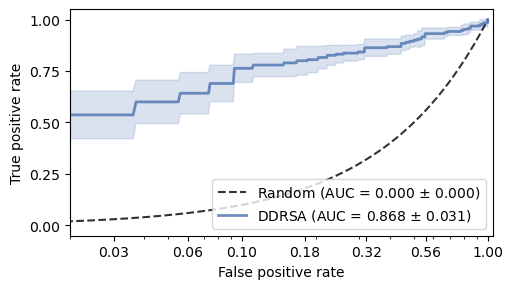

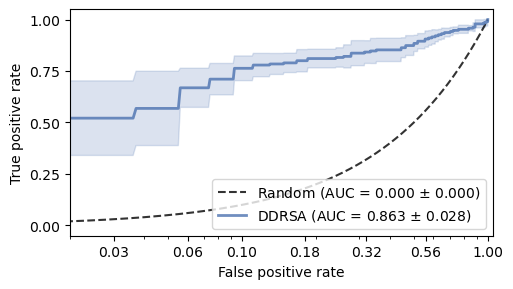

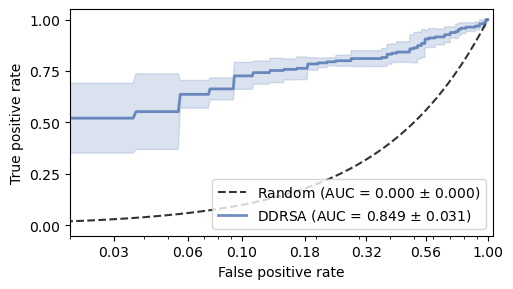

In [17]:
from sklearn import metrics
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('default')
import matplotlib
import pickle


use_sigmoid = True

seed_list = [1234, 1111, 2222, 3333, 4444]
best_pt_path_list = ['ddrsa_eeg_cr3_1234_alpha1.0_beta5_gamma0.5_BSZ32_Lr0.0001_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.4_20230318_0133',
                     'ddrsa_eeg_cr3_1111_alpha1.0_beta1_gamma0.1_BSZ32_Lr0.0001_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.2_20230324_0049',
                     'ddrsa_eeg_cr3_2222_alpha1.0_beta1_gamma0.1_BSZ32_Lr0.0001_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.4_20230317_0946',
                     'ddrsa_eeg_cr3_3333_alpha1.0_beta1_gamma0.05_BSZ32_Lr0.0001_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.4_20230328_0242',
                     'ddrsa_eeg_cr3_4444_alpha1.0_beta5_gamma0.05_BSZ32_Lr0.0001_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.2_20230328_0907',
                    ]

data_mode = 'EEG_cr3' # ['EEG_nocr', 'EEG_cr2', 'EEG_cr4']

if data_mode == 'EEG_cr3':
    path = '../../eeg/competing-risk/EEG_processed_data_long_by_death_cat_exclude_3.csv'

(x_dim, x_dim_cont, x_dim_bin), (data, time, label, time_original, time_to_last), \
    (mask1, mask2, mask3), (data_mi), trans_discrete_time = \
                impt.import_dataset(path)

_, num_Event, num_Category  = np.shape(mask1)  # dim of mask3: [subj, Num_Event, Num_Category]
max_length                  = np.shape(data)[1]

pred_time = list(range(1,13))
eval_time = [24, 48, 72]
mean_fpr = np.linspace(1e-10, 1, 1000)

tprs = []
aucs = []

for e, e_time in enumerate(eval_time):
    print('eval time:', e_time, end=' ')
    tprs = []
    aucs = []
    for r, seed in tqdm(enumerate(seed_list)):

        best_pt_path = best_pt_path_list[r]

        ### TRAINING-TESTING SPLIT
        (tr_data,te_data, tr_data_mi, te_data_mi, tr_time,te_time, tr_label,te_label, tr_time_orinal,te_time_original,
         tr_time_to_last,te_time_to_last,
         tr_mask1,te_mask1, tr_mask2,te_mask2, tr_mask3,te_mask3) = \
                train_test_split(data, data_mi, time, label, time_original, time_to_last,
                                 mask1, mask2, mask3, test_size=0.2, stratify=label, random_state=seed) 

        (tr_data,va_data, tr_data_mi, va_data_mi, tr_time,va_time, tr_label,va_label, tr_time_orinal,va_time_original,
         tr_time_to_last, va_time_to_last,
         tr_mask1,va_mask1, tr_mask2,va_mask2, tr_mask3,va_mask3) = \
                train_test_split(tr_data, tr_data_mi, tr_time, tr_label, tr_time_orinal, tr_time_to_last,
                                 tr_mask1, tr_mask2, tr_mask3, test_size=0.2, stratify=tr_label, random_state=seed) 

        model_name = 'ddrsa_eeg_cr3'
        num_Event = 3

        model = \
            DDRSA(input_dim  = x_dim,
                  output_dim = num_Category,
                  layers_rnn = param['layers_rnn'],
                  hidden_rnn = param['hidden_rnn'],
                  long_param = {'layers': 2*[param['hidden_dim_FC']], 'dropout': dropout}, 
                  att_param  = {'layers': param['hidden_att']*[param['hidden_dim_FC']], 'dropout': dropout}, 
                  cs_param   = {'layers': param['hidden_cs']*[param['hidden_dim_FC']], 'dropout': dropout},
                  risks      = num_Event,
                  use_sigmoid = use_sigmoid
                 )
        optimizer = torch.optim.Adam(model.parameters(), lr = lr_train)
        _ = load_checkpoint(f'checkpoints_ddrsa/{model_name}/{best_pt_path}_{seed}.pt', model, optimizer, device)
        model = model.to(device)

        prob_death_all = np.ones((te_data.shape[0], len(pred_time), len(eval_time)))
        prob_awake_all = np.ones((te_data.shape[0], len(pred_time), len(eval_time)))
        risk_death_old_all = np.ones((te_data.shape[0], len(pred_time), len(eval_time)))

        for p, p_time in enumerate(pred_time):
            pred_horizon = int(p_time)
            out = _f_get_pred(model, te_data, p_time, device)
            risk_death_awaken_all_future = 1 - out[:, :2, :pred_horizon].sum((1,2))

            for t, t_time in enumerate(eval_time):
                eval_horizon = int(t_time) + pred_horizon
                risk_death = out[:, 0, pred_horizon:eval_horizon+1].sum(1)
                risk_awake = out[:, 1, pred_horizon:eval_horizon+1].sum(1)
                risk_death_old = risk_death / (risk_death+risk_awake)
                prob_death = risk_death / risk_death_awaken_all_future
                prob_awake = risk_awake / risk_death_awaken_all_future
                prob_death_all[:, p, t] = prob_death
                prob_awake_all[:, p, t] = prob_awake
                risk_death_old_all[:, p, t] = risk_death_old

        mask = (te_label==1) + (te_label==2) # for only people who died naturally, and who awoke

        scores = -(prob_awake_all / prob_death_all)[:, 5, e]
        fpr, tpr, thresholds = metrics.roc_curve(te_label[mask], scores[mask.flatten()], 
                                                 pos_label=1)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        roc_auc = metrics.auc(fpr, tpr)

        tprs.append(interp_tpr)
        aucs.append(roc_auc)

    n_std = 1
    scale = 'log' # {'log', 'linear'}

    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(3, 2, 1)
    ax.plot(mean_fpr, mean_fpr, linestyle='--', color='black', alpha=.8,
            label=r'%s (AUC = %0.3f $\pm$ %0.3f)' % ('Random', 0, 0))

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
            label=r'%s (AUC = %0.3f $\pm$ %0.3f)' % ('DDRSA', mean_auc, n_std*std_auc),
            lw=2, alpha=.8)
    print(r'%s (AUC = %0.3f ± %0.3f)' % ('DDRSA', mean_auc, n_std*std_auc))
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + n_std*std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - n_std*std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='b', alpha=.2)

    plt.xlim([2e-2, 5])
    plt.yticks([0.00,0.25,0.50,0.75,1.00])
    if scale == 'log':
        ax.set_xscale(scale)
        ax.set_xticks([0.03, 0.06, 0.10, 0.18, 0.32, 0.56, 1.00])
        ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           # title=r'Mean ROC with $\pm$ %0.1f std. dev.' % (n_std)
          )
    ax.legend(loc='lower right')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    
    auc_info = {'mean_tpr': mean_tpr, 'mean_auc': mean_auc, 'std_auc': std_auc, 'tprs': tprs}
    with open(f'ddrsa_auc_info_{6}_{e_time}.pickle', 'wb') as handle:
        pickle.dump(auc_info,
                    handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    fname = r'ROC_%s_%d_%d.pdf' % ('DDRSA', 6, e_time)
    plt.savefig(fname, dpi=200, format='pdf', bbox_inches='tight')
    # plt.show()
   

/heinz-georgenas/anaconda3/envs/py39xiaobin/lib/python3.9/site-packages/pycox/preprocessing/label_transforms.py:113: UserWarning: Calling fit method, when 'cuts' are already defined. Leaving cuts unchanged.
  warnings.warn("Calling fit method, when 'cuts' are already defined. Leaving cuts unchanged.")


eval time: 24 

5it [00:06,  1.32s/it]
/tmp/ipykernel_2964573/3238421982.py:139: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],


DDRSA (AUC = 0.871 ± 0.015)
eval time: 48 

5it [00:08,  1.71s/it]
/tmp/ipykernel_2964573/3238421982.py:139: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],


DDRSA (AUC = 0.853 ± 0.019)
eval time: 72 

5it [00:05,  1.17s/it]
/tmp/ipykernel_2964573/3238421982.py:139: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],


DDRSA (AUC = 0.822 ± 0.020)


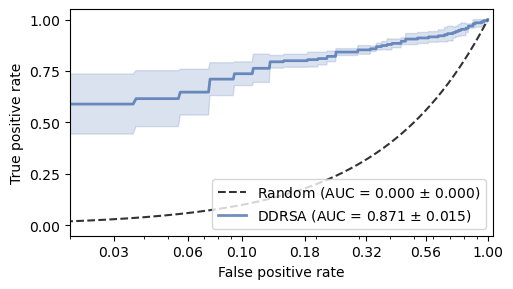

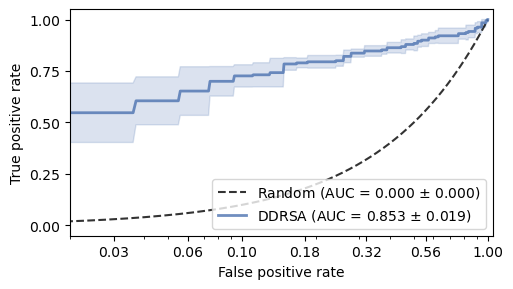

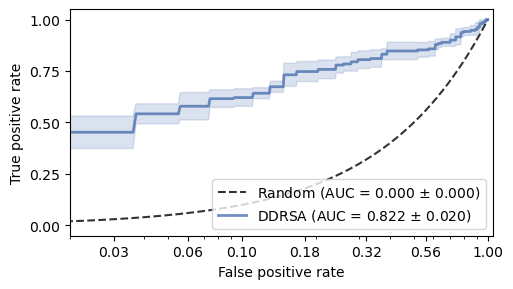

In [18]:
from sklearn import metrics
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('default')
import matplotlib
import pickle


use_sigmoid = True

seed_list = [1234, 1111, 2222, 3333, 4444]
best_pt_path_list = ['ddrsa_eeg_cr3_1234_alpha1.0_beta5_gamma0.5_BSZ32_Lr0.0001_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.4_20230318_0133',
                     'ddrsa_eeg_cr3_1111_alpha1.0_beta1_gamma0.1_BSZ32_Lr0.0001_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.2_20230324_0049',
                     'ddrsa_eeg_cr3_2222_alpha1.0_beta1_gamma0.1_BSZ32_Lr0.0001_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.4_20230317_0946',
                     'ddrsa_eeg_cr3_3333_alpha1.0_beta1_gamma0.05_BSZ32_Lr0.0001_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.4_20230328_0242',
                     'ddrsa_eeg_cr3_4444_alpha1.0_beta5_gamma0.05_BSZ32_Lr0.0001_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.2_20230328_0907',
                    ]

data_mode = 'EEG_cr3' # ['EEG_nocr', 'EEG_cr2', 'EEG_cr4']

if data_mode == 'EEG_cr3':
    path = '../../eeg/competing-risk/EEG_processed_data_long_by_death_cat_exclude_3.csv'

(x_dim, x_dim_cont, x_dim_bin), (data, time, label, time_original, time_to_last), \
    (mask1, mask2, mask3), (data_mi), trans_discrete_time = \
                impt.import_dataset(path)

_, num_Event, num_Category  = np.shape(mask1)  # dim of mask3: [subj, Num_Event, Num_Category]
max_length                  = np.shape(data)[1]

pred_time = list(range(1,13))
eval_time = [24, 48, 72]
mean_fpr = np.linspace(1e-10, 1, 1000)

tprs = []
aucs = []

for e, e_time in enumerate(eval_time):
    print('eval time:', e_time, end=' ')
    tprs = []
    aucs = []
    for r, seed in tqdm(enumerate(seed_list)):

        best_pt_path = best_pt_path_list[r]

        ### TRAINING-TESTING SPLIT
        (tr_data,te_data, tr_data_mi, te_data_mi, tr_time,te_time, tr_label,te_label, tr_time_orinal,te_time_original,
         tr_time_to_last,te_time_to_last,
         tr_mask1,te_mask1, tr_mask2,te_mask2, tr_mask3,te_mask3) = \
                train_test_split(data, data_mi, time, label, time_original, time_to_last,
                                 mask1, mask2, mask3, test_size=0.2, stratify=label, random_state=seed) 

        (tr_data,va_data, tr_data_mi, va_data_mi, tr_time,va_time, tr_label,va_label, tr_time_orinal,va_time_original,
         tr_time_to_last, va_time_to_last,
         tr_mask1,va_mask1, tr_mask2,va_mask2, tr_mask3,va_mask3) = \
                train_test_split(tr_data, tr_data_mi, tr_time, tr_label, tr_time_orinal, tr_time_to_last,
                                 tr_mask1, tr_mask2, tr_mask3, test_size=0.2, stratify=tr_label, random_state=seed) 

        model_name = 'ddrsa_eeg_cr3'
        num_Event = 3

        model = \
            DDRSA(input_dim  = x_dim,
                  output_dim = num_Category,
                  layers_rnn = param['layers_rnn'],
                  hidden_rnn = param['hidden_rnn'],
                  long_param = {'layers': 2*[param['hidden_dim_FC']], 'dropout': dropout}, 
                  att_param  = {'layers': param['hidden_att']*[param['hidden_dim_FC']], 'dropout': dropout}, 
                  cs_param   = {'layers': param['hidden_cs']*[param['hidden_dim_FC']], 'dropout': dropout},
                  risks      = num_Event,
                  use_sigmoid = use_sigmoid
                 )
        optimizer = torch.optim.Adam(model.parameters(), lr = lr_train)
        _ = load_checkpoint(f'checkpoints_ddrsa/{model_name}/{best_pt_path}_{seed}.pt', model, optimizer, device)
        model = model.to(device)

        prob_death_all = np.ones((te_data.shape[0], len(pred_time), len(eval_time)))
        prob_awake_all = np.ones((te_data.shape[0], len(pred_time), len(eval_time)))
        risk_death_old_all = np.ones((te_data.shape[0], len(pred_time), len(eval_time)))

        for p, p_time in enumerate(pred_time):
            pred_horizon = int(p_time)
            out = _f_get_pred(model, te_data, p_time, device)
            risk_death_awaken_all_future = 1 - out[:, :2, :pred_horizon].sum((1,2))

            for t, t_time in enumerate(eval_time):
                eval_horizon = int(t_time) + pred_horizon
                risk_death = out[:, 0, pred_horizon:eval_horizon+1].sum(1)
                risk_awake = out[:, 1, pred_horizon:eval_horizon+1].sum(1)
                risk_death_old = risk_death / (risk_death+risk_awake)
                prob_death = risk_death / risk_death_awaken_all_future
                prob_awake = risk_awake / risk_death_awaken_all_future
                prob_death_all[:, p, t] = prob_death
                prob_awake_all[:, p, t] = prob_awake
                risk_death_old_all[:, p, t] = risk_death_old

        mask = (te_label==1) + (te_label==2) # for only people who died naturally, and who awoke

        scores = -(prob_awake_all / prob_death_all)[:, -1, e]
        fpr, tpr, thresholds = metrics.roc_curve(te_label[mask], scores[mask.flatten()], 
                                                 pos_label=1)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        roc_auc = metrics.auc(fpr, tpr)

        tprs.append(interp_tpr)
        aucs.append(roc_auc)

    n_std = 1
    scale = 'log' # {'log', 'linear'}

    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(3, 2, 1)
    ax.plot(mean_fpr, mean_fpr, linestyle='--', color='black', alpha=.8,
            label=r'%s (AUC = %0.3f $\pm$ %0.3f)' % ('Random', 0, 0))

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
            label=r'%s (AUC = %0.3f $\pm$ %0.3f)' % ('DDRSA', mean_auc, n_std*std_auc),
            lw=2, alpha=.8)
    print(r'%s (AUC = %0.3f ± %0.3f)' % ('DDRSA', mean_auc, n_std*std_auc))
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + n_std*std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - n_std*std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='b', alpha=.2)

    plt.xlim([2e-2, 5])
    plt.yticks([0.00,0.25,0.50,0.75,1.00])
    if scale == 'log':
        ax.set_xscale(scale)
        ax.set_xticks([0.03, 0.06, 0.10, 0.18, 0.32, 0.56, 1.00])
        ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           # title=r'Mean ROC with $\pm$ %0.1f std. dev.' % (n_std)
          )
    ax.legend(loc='lower right')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    
    auc_info = {'mean_tpr': mean_tpr, 'mean_auc': mean_auc, 'std_auc': std_auc, 'tprs': tprs}
    with open(f'ddrsa_auc_info_{12}_{e_time}.pickle', 'wb') as handle:
        pickle.dump(auc_info,
                    handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    fname = r'ROC_%s_%d_%d.pdf' % ('DDRSA', 12, e_time)
    plt.savefig(fname, dpi=200, format='pdf', bbox_inches='tight')
    # plt.show()
   

# Part III: Test the model

In [81]:
def eval_model(model, te_data, pred_time, eval_time, num_Event, device='cuda'):
    # pred_time = [4, 8, 12]
    # eval_time = [12, 24, 36, 48, 60, 72]

    risk_all = f_get_risk_predictions(model, te_data, pred_time, eval_time, device=device)

    for p, p_time in enumerate(pred_time):
        pred_horizon = int(p_time)
        result1, result2 = np.zeros([num_Event, len(eval_time)]), np.zeros([num_Event, len(eval_time)])

        for t, t_time in enumerate(eval_time):                
            eval_horizon = int(t_time) + pred_horizon
            for k in range(num_Event):
                result1[k, t] = c_index(risk_all[k][:, p, t], te_time, (te_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
                result2[k, t] = brier_score(risk_all[k][:, p, t], te_time, (te_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)

        if p == 0:
            final1, final2 = result1, result2
        else:
            final1, final2 = np.append(final1, result1, axis=0), np.append(final2, result2, axis=0)


    row_header = []
    for p_time in pred_time:
        for k in range(num_Event):
            row_header.append('pred_time {}: event_{}'.format(p_time, k+1))

    col_header = []
    for t_time in eval_time:
        col_header.append('eval_time {}'.format(t_time))

    # c-index result
    df1 = pd.DataFrame(final1, index = row_header, columns=col_header)

    # brier-score result
    df2 = pd.DataFrame(final2, index = row_header, columns=col_header)

    ### PRINT RESULTS
    print('========================================================')
    print('--------------------------------------------------------')
    print('- C-INDEX: ')
    print(df1)
    print('--------------------------------------------------------')
    print('- BRIER-SCORE: ')
    print(df2)
    print('========================================================')
    
    return df1, df2

In [10]:
from ddh_torch import DynamicDeepHitTorch
from ddrsa import DDRSA

### three competing risk
- 1: Death (Rearrested, intractable shock, multisystem organ failure; Brain death)
- 2: Awake
- ~~3: Withdrawal for non-neurological reasons (DNR, advanced directives, etc)~~
- 3: Withdrawal for perceived poor neurological prognosis

In [82]:
seed = SEED

data_mode = 'EEG_cr3' # ['EEG_nocr', 'EEG_cr2', 'EEG_cr4']

if data_mode == 'EEG_nocr':
    path = '../../eeg/varying-seq-len/EEG_processed_data_long.csv'
elif data_mode == 'EEG_cr2':
    path = '../../eeg/competing-risk/EEG_processed_data_long.csv'
elif data_mode == 'EEG_cr4':
    path = '../../eeg/competing-risk/EEG_processed_data_long_by_death_cat.csv'
elif data_mode == 'EEG_cr3':
    path = '../../eeg/competing-risk/EEG_processed_data_long_by_death_cat_exclude_3.csv'

(x_dim, x_dim_cont, x_dim_bin), (data, time, label, time_original, time_to_last), \
    (mask1, mask2, mask3), (data_mi), trans_discrete_time = \
                impt.import_dataset(path)

_, num_Event, num_Category  = np.shape(mask1)  # dim of mask3: [subj, Num_Event, Num_Category]
max_length                  = np.shape(data)[1]

### TRAINING-TESTING SPLIT
(tr_data,te_data, tr_data_mi, te_data_mi, tr_time,te_time, tr_label,te_label, tr_time_orinal,te_time_original,
 tr_time_to_last,te_time_to_last,
 tr_mask1,te_mask1, tr_mask2,te_mask2, tr_mask3,te_mask3) = \
        train_test_split(data, data_mi, time, label, time_original, time_to_last,
                         mask1, mask2, mask3, test_size=0.2, stratify=label, random_state=seed) 

(tr_data,va_data, tr_data_mi, va_data_mi, tr_time,va_time, tr_label,va_label, tr_time_orinal,va_time_original,
 tr_time_to_last, va_time_to_last,
 tr_mask1,va_mask1, tr_mask2,va_mask2, tr_mask3,va_mask3) = \
        train_test_split(tr_data, tr_data_mi, tr_time, tr_label, tr_time_orinal, tr_time_to_last,
                         tr_mask1, tr_mask2, tr_mask3, test_size=0.2, stratify=tr_label, random_state=seed) 

num_Event

/heinz-georgenas/anaconda3/envs/py39xiaobin/lib/python3.9/site-packages/pycox/preprocessing/label_transforms.py:113: UserWarning: Calling fit method, when 'cuts' are already defined. Leaving cuts unchanged.
  warnings.warn("Calling fit method, when 'cuts' are already defined. Leaving cuts unchanged.")


3

#### DDRSA

In [39]:
pred_time = [6,12]
eval_time = [24, 48, 72, 96]
model_name = 'ddrsa_eeg_cr3'

use_sigmoid = False
hidden_att  = 3
hidden_cs   = 3

best_pt_path = 'ddrsa_eeg_cr3_1234_alpha1.0_beta5_gamma0.5_BSZ32_Lr0.0001_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.4_20230318_0133'
best_pt_path = 'ddrsa_eeg_cr3_1234_sigmoidFalse_alpha1.0_beta0.5_gamma0.05_BSZ32_Lr0.0001_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt3_hiddenCS3_dropout0.4_20230323_1331'
# best_pt_path = 'ddrsa_eeg_cr3_1111_alpha1.0_beta1_gamma0.1_BSZ32_Lr0.0001_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.2_20230324_0049'
# best_pt_path = 'ddrsa_eeg_cr3_2222_alpha1.0_beta1_gamma0.1_BSZ32_Lr0.0001_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.4_20230317_0946'
# best_pt_path = 'ddrsa_eeg_cr3_3333_alpha1.0_beta1_gamma0.05_BSZ32_Lr0.0001_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.4_20230328_0242'
# best_pt_path = 'ddrsa_eeg_cr3_4444_alpha1.0_beta5_gamma0.05_BSZ32_Lr0.0001_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.2_20230328_0907'
model = \
    DDRSA(input_dim  = x_dim,
              output_dim = num_Category,
              layers_rnn = param['layers_rnn'],
              hidden_rnn = param['hidden_rnn'],
              long_param = {'layers': 2*[param['hidden_dim_FC']], 'dropout': dropout}, 
              # att_param  = {'layers': param['hidden_att']*[param['hidden_dim_FC']], 'dropout': dropout}, 
              # cs_param   = {'layers': param['hidden_cs']*[param['hidden_dim_FC']], 'dropout': dropout},
              att_param  = {'layers': 3*[param['hidden_dim_FC']], 'dropout': dropout}, 
              cs_param   = {'layers': 3*[param['hidden_dim_FC']], 'dropout': dropout},
              risks      = num_Event,
              use_sigmoid = use_sigmoid
             )
optimizer = torch.optim.Adam(model.parameters(), lr = lr_train)
_ = load_checkpoint(f'checkpoints_ddrsa/{model_name}/{best_pt_path}_{SEED}.pt', model, optimizer, device)
model = model.to(device)

df1, df2 = eval_model(model, te_data, pred_time, eval_time, num_Event)

--------------------------------------------------------
- C-INDEX: 
                       eval_time 24  eval_time 48  eval_time 72  eval_time 96
pred_time 6: event_1       0.671414      0.648041      0.689655      0.724554
pred_time 6: event_2       0.803154      0.847145      0.838727      0.821962
pred_time 6: event_3       0.617995      0.545581      0.603801      0.597442
pred_time 12: event_1      0.759639      0.715438      0.729443      0.727899
pred_time 12: event_2      0.799552      0.787920      0.791343      0.769490
pred_time 12: event_3      0.536557      0.577127      0.607293      0.605910
--------------------------------------------------------
- BRIER-SCORE: 
                       eval_time 24  eval_time 48  eval_time 72  eval_time 96
pred_time 6: event_1       0.038770      0.078816      0.107982      0.122266
pred_time 6: event_2       0.052299      0.099254      0.127955      0.142834
pred_time 6: event_3       0.083791      0.154161      0.190634      0.205454


### c-index

In [40]:
df1[::3] # 1: death

,eval_time 24,eval_time 48,eval_time 72,eval_time 96
pred_time 6: event_1,0.671414,0.648041,0.689655,0.724554
pred_time 12: event_1,0.759639,0.715438,0.729443,0.727899


In [41]:
df1[1::3] # 2: awake

,eval_time 24,eval_time 48,eval_time 72,eval_time 96
pred_time 6: event_2,0.803154,0.847145,0.838727,0.821962
pred_time 12: event_2,0.799552,0.787920,0.791343,0.769490


In [42]:
df1[2::3] # 3: Withdrawal for perceived poor neurological prognosis

,eval_time 24,eval_time 48,eval_time 72,eval_time 96
pred_time 6: event_3,0.617995,0.545581,0.603801,0.597442
pred_time 12: event_3,0.536557,0.577127,0.607293,0.605910


### predicted survival time

In [43]:
from pycox.models import utils

def interpolate_surv_fn(surv, trans_discrete_time, sub=10):
    '''
    surv: an array of predicted survival score, (N, num_discrete_time)
    trans_discrete_time: an instance of the LabTransDiscreteTime class in pycox
    sub: interpolate by how much
    
    return: surv and index after interpolation
    '''
    s = torch.tensor(surv)
    n, m = s.shape
    device = s.device
    diff = (s[:, 1:] - s[:, :-1]).contiguous().view(-1, 1).repeat(1, sub).view(n, -1)
    rho = torch.linspace(0, 1, sub+1)[:-1].contiguous().repeat(n, m-1)
    s_prev = s[:, :-1].contiguous().view(-1, 1).repeat(1, sub).view(n, -1)
    surv_intp = torch.zeros(n, int((m-1)*sub + 1))
    surv_intp[:, :-1] = diff * rho + s_prev
    surv_intp[:, -1] = s[:, -1]
    surv_intp = surv_intp.numpy()
    index_intp = np.array(utils.make_subgrid(trans_discrete_time.cuts, sub))
    
    return surv_intp, index_intp

method 1

In [44]:
out = _f_get_pred(model, te_data, 12, device)
pred_surv = 1 - out.sum(1).cumsum(1) # # probability of still-in-coma curve
intp_surv, intp_index = interpolate_surv_fn(pred_surv, trans_discrete_time, sub=1)
out.shape, pred_surv.shape

((185, 3, 120), (185, 120))

In [45]:
out

array([[[2.7717317e-06, 8.3754545e-05, 1.4904300e-05, ...,
         3.3719409e-03, 3.2255189e-03, 3.0358068e-03],
        [3.3756546e-03, 3.2275859e-03, 3.0352010e-03, ...,
         3.3982405e-03, 3.2438054e-03, 3.0338364e-03],
        [3.3978003e-03, 3.2435362e-03, 3.0339488e-03, ...,
         3.3946657e-03, 3.2357767e-03, 3.0368729e-03]],

       [[4.4895630e-04, 8.8669849e-04, 1.8289867e-03, ...,
         2.9637595e-03, 1.0076649e-03, 1.6760309e-03],
        [2.9643914e-03, 1.0025140e-03, 1.6738425e-03, ...,
         2.4706253e-03, 8.2654034e-04, 1.7583159e-03],
        [2.4595049e-03, 8.2597142e-04, 1.7615692e-03, ...,
         6.3441740e-03, 1.4655862e-03, 7.2917612e-03]],

       [[4.3093874e-06, 1.3044130e-04, 7.6373108e-05, ...,
         2.8570632e-03, 3.4305309e-03, 4.4247508e-03],
        [2.8912053e-03, 3.3901248e-03, 4.3888357e-03, ...,
         3.1926539e-03, 3.4825772e-03, 3.6605317e-03],
        [3.1925701e-03, 3.4825776e-03, 3.6606088e-03, ...,
         3.2223172e-03, 3

In [46]:
median_idx = np.argmax(pred_surv<0.5, axis=1)
intp_index_repeat = np.repeat(intp_index.reshape(1,-1), out.shape[0], axis=0)
median_time = intp_index_repeat[np.arange(len(intp_index_repeat)), median_idx]
cum_risk = np.cumsum(out, axis=2)
# pred_k: the most probable event happen at median surv time
pred_k = cum_risk[np.arange(len(cum_risk)), :, median_idx].argmax(1) 
median_time[:5], pred_k[:5]

(array([68., 62., 62., 67., 63.]), array([1, 2, 1, 2, 2]))

In [47]:
risk_all = f_get_risk_predictions(model, te_data, pred_time, eval_time, device=device)

In [48]:
from scipy import integrate
def f_get_condition_cif_func(model, data_, pred_horizon, device):
    '''
    pred_horizon: scalar
    return the conditonal CIF func of each obs
    '''
    pred = _f_get_pred(model, data_[[0]], 0, device)
    _, num_Event, num_Category = pred.shape
    
    pred_horizon = int(pred_horizon)
    pred = _f_get_pred(model, data_, pred_horizon, device)
    
    # condition on already survive until pred_horizon
    s = np.sum(pred[:, :, pred_horizon:], (1,2)).reshape(-1,1,1) # prob. of survival beyond pred_horizon
    return pred / s

def f_get_rmean_surv_time(cif_pred, pred_horizon, eval_time, delta_t, method=None):
    '''
    method: {trapezoid, cumulative_trapezoid, simpson, romb}
    return restricted mean survival time by pred_horizon + eval_time
    At pred_horizon, predicting the mean survival time in the next eval_time duration
    '''
    eval_time = int(eval_time)
    pred_surv = 1 - cif_pred[:, :, pred_horizon:].sum(1).cumsum(1) # probability of still-in-coma curve
    delta_t = delta_t[pred_horizon:]
    if method is None:
        mean_surv_time = (pred_surv[:, 1:eval_time] * delta_t[:eval_time-1]).sum(1)
    elif method == 'trapezoid':
        mean_surv_time = integrate.trapezoid(pred_surv[:, 1:eval_time], dx=delta_t[:eval_time-2])
    elif method == 'cumulative_trapezoid':
        mean_surv_time = integrate.cumulative_trapezoid(pred_surv[:, 1:eval_time], dx=delta_t[:eval_time-2])
    elif method == 'simpson':
        mean_surv_time = integrate.simpson(pred_surv[:, 1:eval_time], dx=delta_t[:eval_time-2])
    elif method == 'romb':
        mean_surv_time = integrate.romb(pred_surv[:, 1:eval_time], dx=delta_t[:eval_time-2])
    
    return mean_surv_time

def f_get_cause_specific_loss_time(cif_pred, pred_horizon, eval_time, delta_t):
    cif_pred = cif_pred[:, :, pred_horizon:]
    cs_loss_time = np.sum(cif_pred[:, :, 1:eval_time] * delta_t[:eval_time-1], (2))
    return cs_loss_time

In [49]:
pred_horizon = 12
eval_time = 108
cif_pred = f_get_condition_cif_func(model, te_data, pred_horizon, device)
delta_t = np.diff(trans_discrete_time.cuts) # len of duration for each discretized interval

mean_surv_time = f_get_rmean_surv_time(cif_pred, pred_horizon, eval_time, delta_t)
mean_surv_time

cs_loss_time = f_get_cause_specific_loss_time(cif_pred, pred_horizon, eval_time, delta_t)

In [50]:
cs_loss_time

array([[0.27878932, 0.4116024 , 0.41109484],
       [0.25358359, 0.22192414, 0.6088019 ],
       [0.24374274, 0.44581715, 0.41699991],
       [0.18438581, 0.46586808, 0.46147403],
       [0.15222666, 0.45395009, 0.48995102],
       [0.05923258, 0.39748961, 0.65851472],
       [0.18883173, 0.21255771, 0.68688539],
       [0.21011681, 0.19666566, 0.68560003],
       [0.28253006, 0.4296608 , 0.39308502],
       [0.05979602, 0.39854182, 0.65938331],
       [0.12737796, 0.44594231, 0.5244027 ],
       [0.18562411, 0.19919968, 0.7150912 ],
       [0.16633915, 0.19380428, 0.72962609],
       [0.12487532, 0.40597274, 0.57333645],
       [0.34476853, 0.37608272, 0.38223844],
       [0.11248427, 0.47818065, 0.50679248],
       [0.1356216 , 0.29682379, 0.68456708],
       [0.11248161, 0.40108933, 0.59325229],
       [0.18821203, 0.21498668, 0.70744717],
       [0.07803509, 0.4293048 , 0.60022442],
       [0.17271882, 0.21868313, 0.70602215],
       [0.18217019, 0.29259172, 0.64732118],
       [0.

In [51]:
from scipy.stats import pearsonr
def cal_pearsonr(a,b):
    return pearsonr(a, b)[0]

death_mask = te_label.flatten() == 1
awake_mask = te_label.flatten() == 2
withdrawl_mask = te_label.flatten() == 3
non_censor_mask = (te_label.flatten() != 0)

print(cal_pearsonr(mean_surv_time[non_censor_mask], te_time.flatten()[non_censor_mask]))
print(cal_pearsonr(mean_surv_time[awake_mask], te_time.flatten()[awake_mask]))
print(cal_pearsonr(mean_surv_time[death_mask], te_time.flatten()[death_mask]))
print(cal_pearsonr(mean_surv_time[withdrawl_mask], te_time.flatten()[withdrawl_mask]))

0.10052621274181692
0.09052484146078717
0.052805835721941946
0.06519942657131082


method 2
To-Do

In [54]:
# the probability of each event not yet happen
prob_not_happen = cum_risk[:, :, -1:].repeat(out.shape[2], axis=2) - cum_risk
i = 0
k = 0
prob_not_happen[i, k]

array([0.22611801, 0.22603425, 0.22601935, 0.22580881, 0.22542916,
       0.225392  , 0.22504641, 0.2245625 , 0.22451963, 0.22410923,
       0.2235791 , 0.22353409, 0.22308615, 0.22253296, 0.22248638,
       0.22201747, 0.22145092, 0.2214021 , 0.22091202, 0.22032464,
       0.22027215, 0.21976107, 0.21912844, 0.21907203, 0.21854773,
       0.21785598, 0.21779613, 0.21726388, 0.21652433, 0.21646151,
       0.21592405, 0.2151509 , 0.21508525, 0.21454374, 0.21374139,
       0.21367037, 0.213123  , 0.21227685, 0.21218334, 0.21161433,
       0.21069609, 0.21052368, 0.20986645, 0.20885797, 0.20854461,
       0.20768467, 0.20653604, 0.20611084, 0.20507862, 0.2038263 ,
       0.2033469 , 0.20223795, 0.20093293, 0.20039824, 0.19915348,
       0.19767112, 0.19695841, 0.19520414, 0.19299082, 0.19142266,
       0.18910182, 0.18634856, 0.18383399, 0.18115766, 0.17828107,
       0.1751584 , 0.17190512, 0.16887477, 0.16547018, 0.16175239,
       0.15853006, 0.15528427, 0.15143439, 0.14818901, 0.14500

### individual visualization

patient 46 time: 43.0 label: 2.0 awake


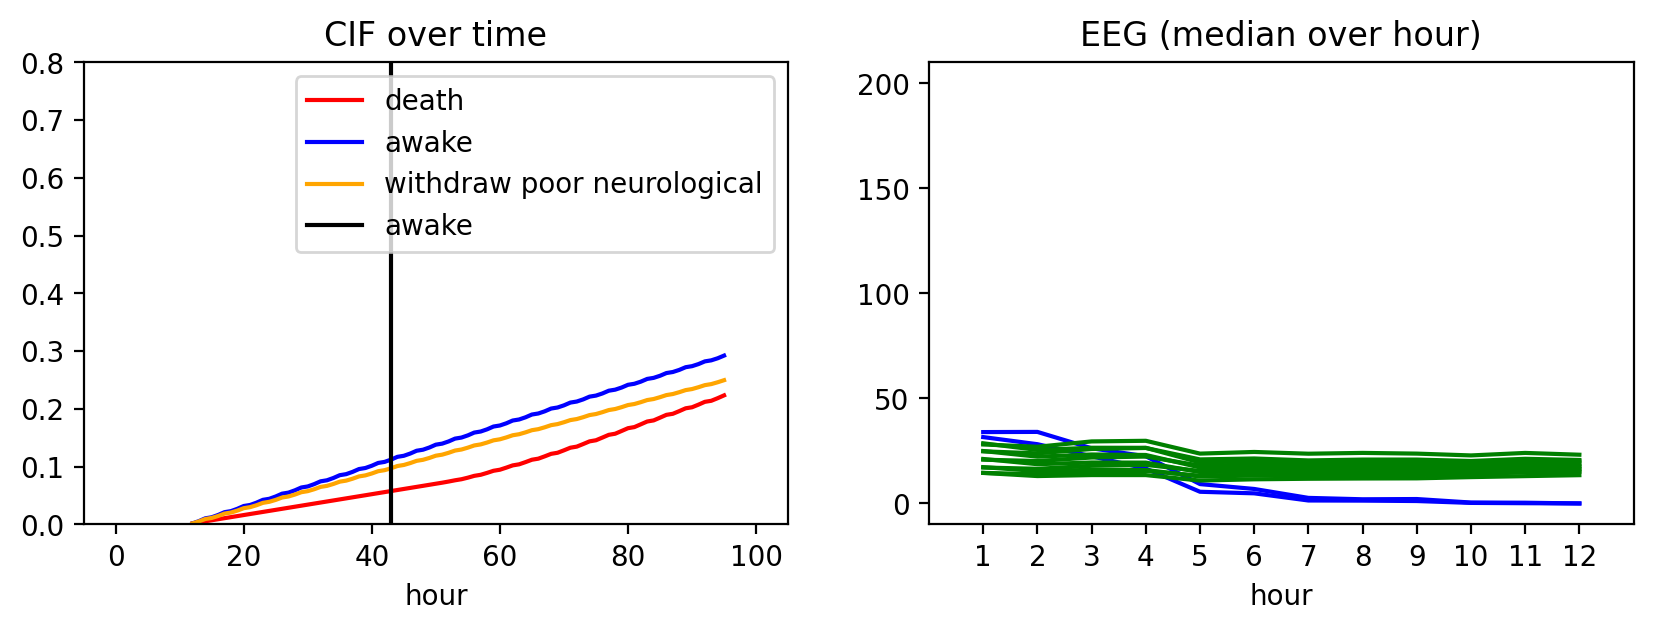

patient 11 time: 74.0 label: 1.0 death


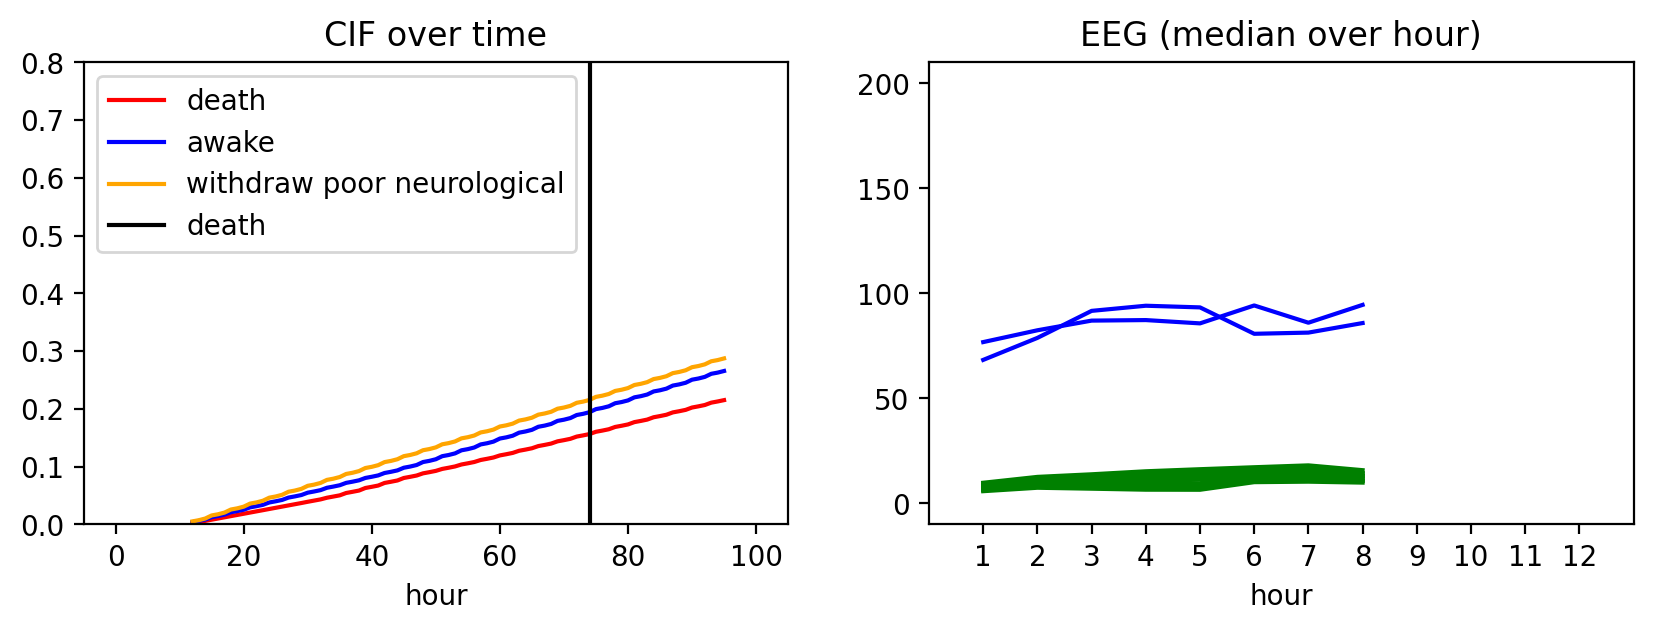

patient 50 time: 106.0 label: 1.0 death


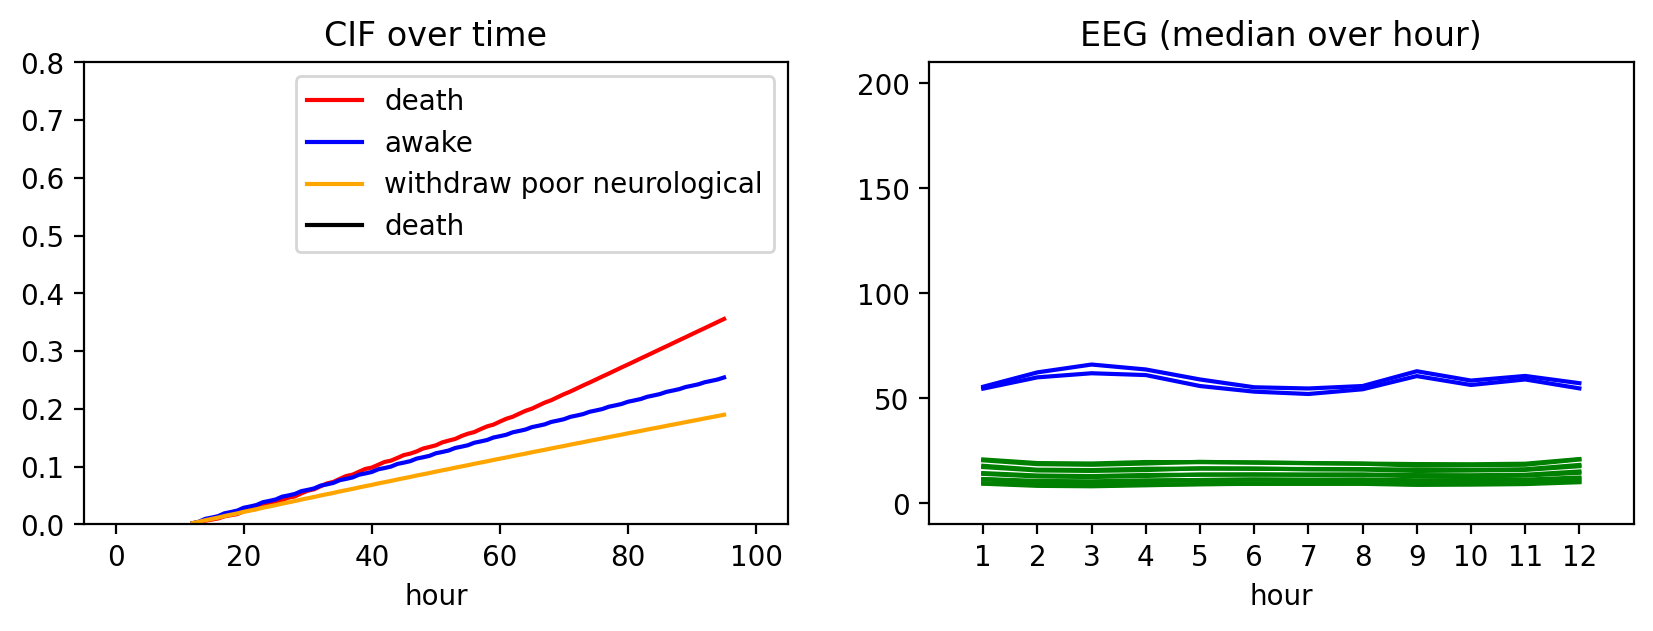

patient 20 time: 118.0 label: 0.0 censor


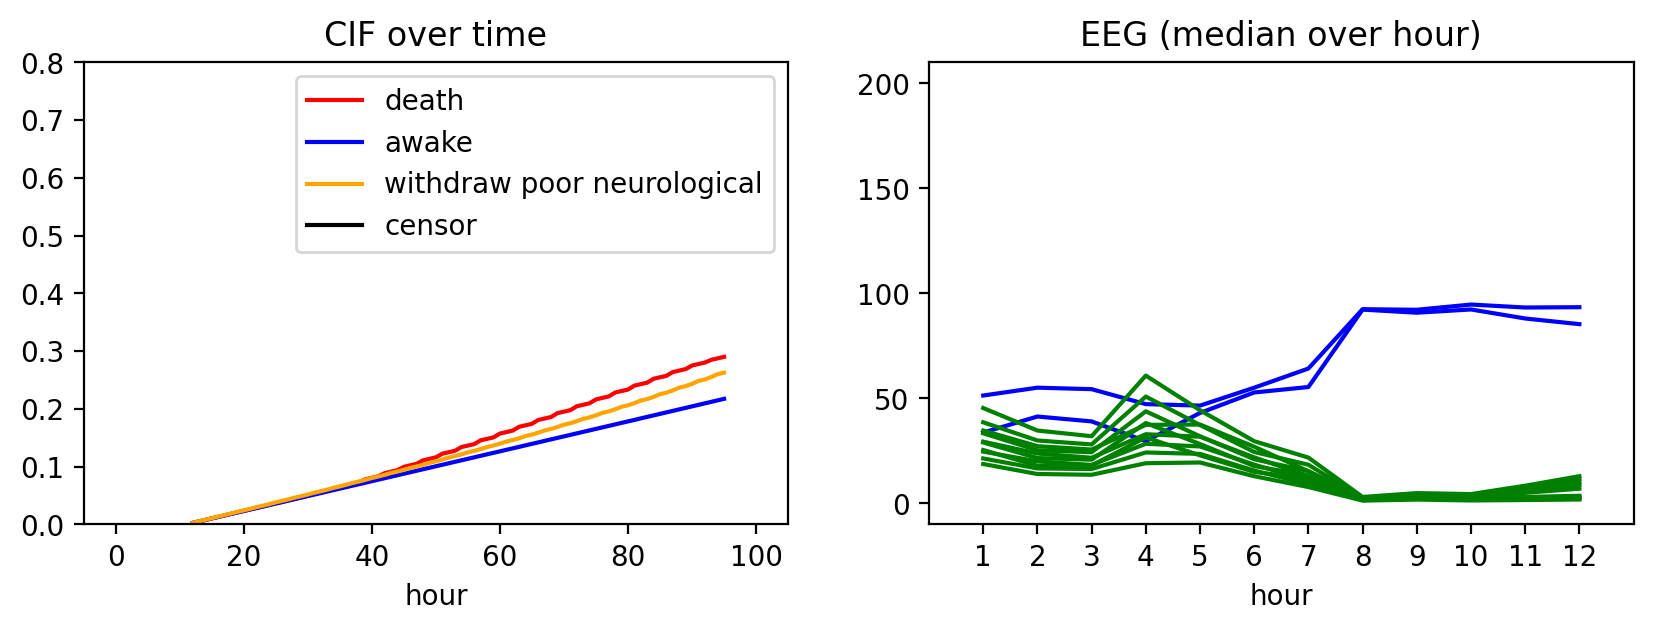

patient 60 time: 48.0 label: 2.0 awake


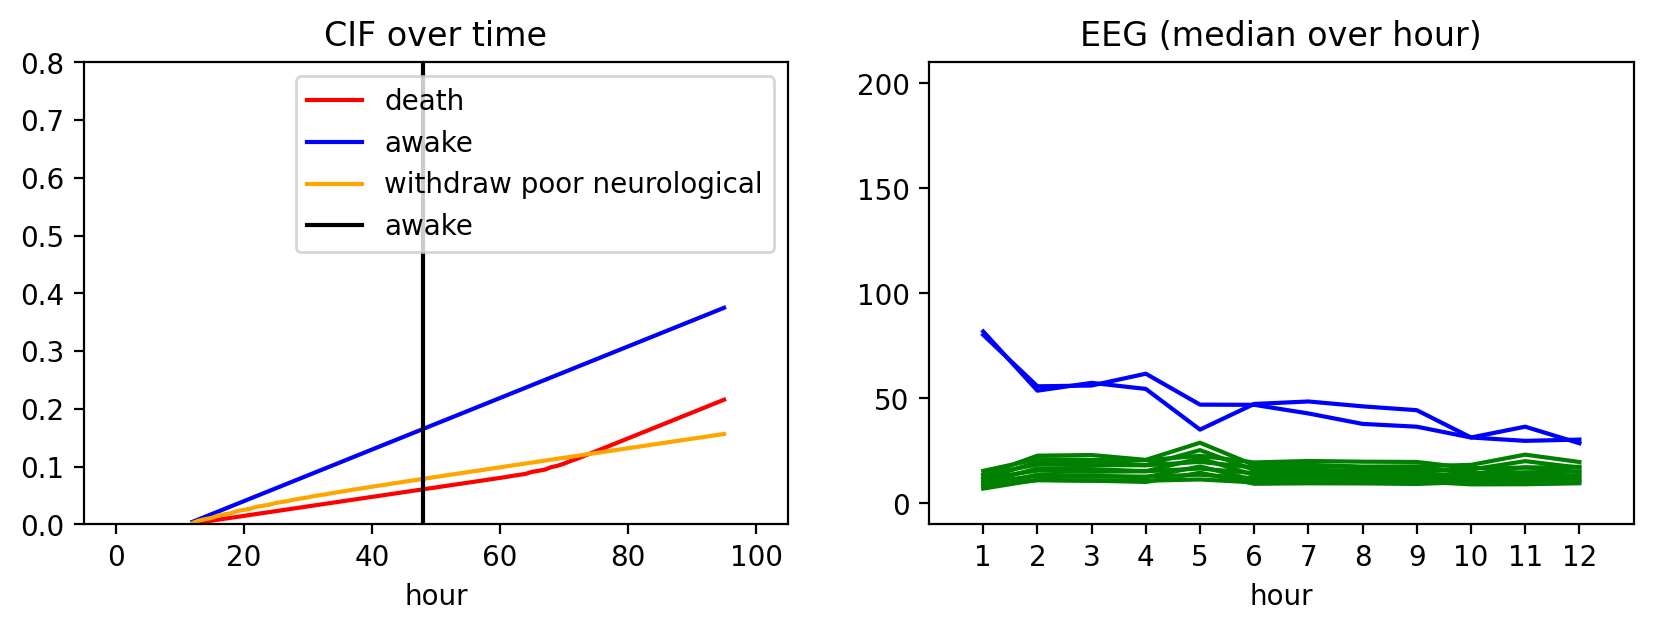

patient 80 time: 90.0 label: 2.0 awake


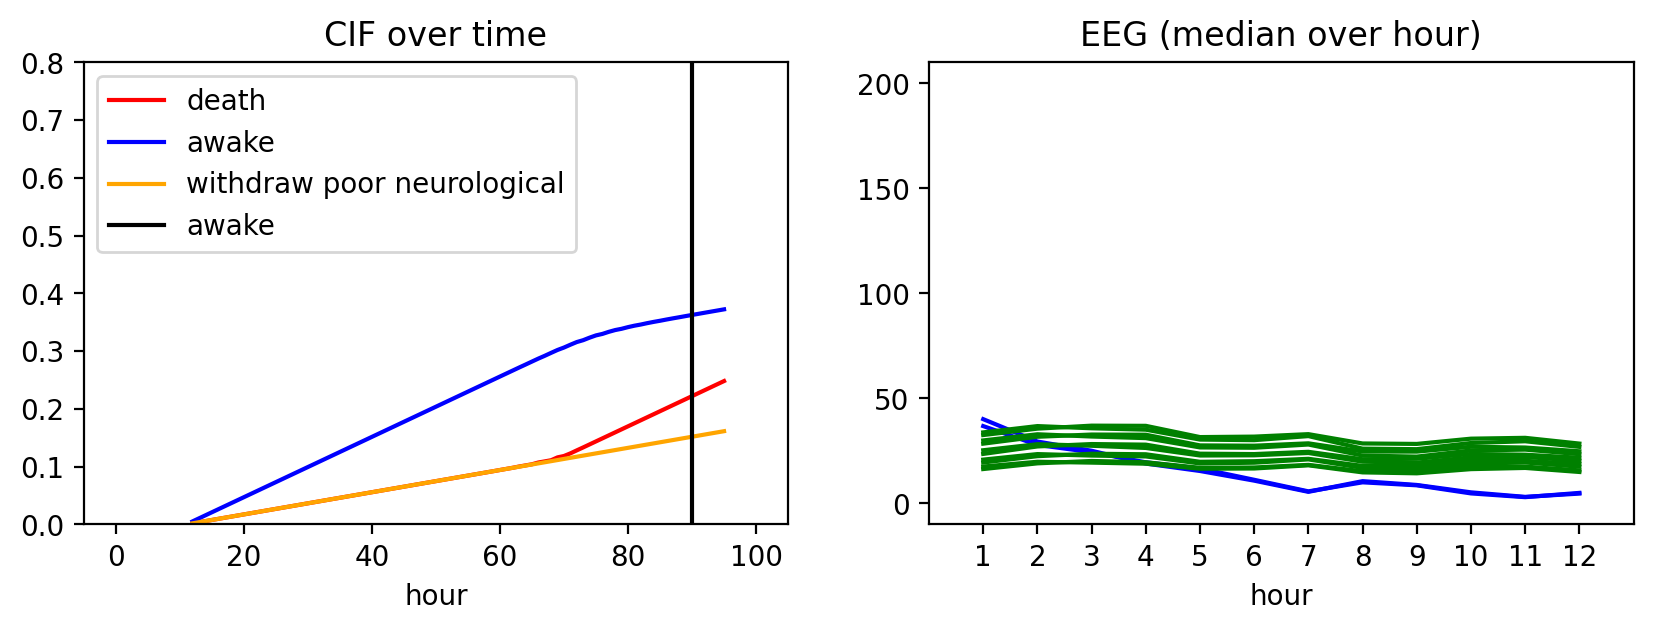

patient 21 time: 97.0 label: 3.0 withdraw poor neurological


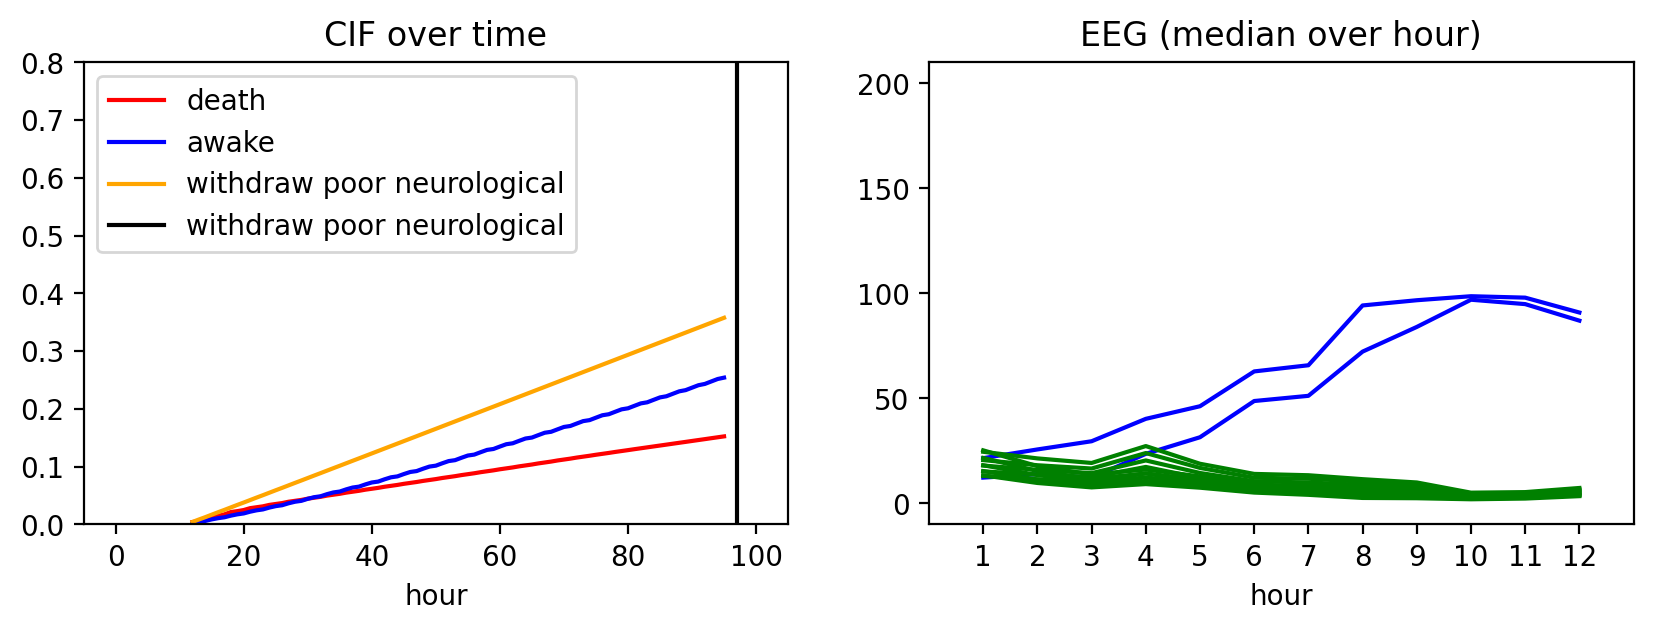

patient 22 time: 26.0 label: 2.0 awake


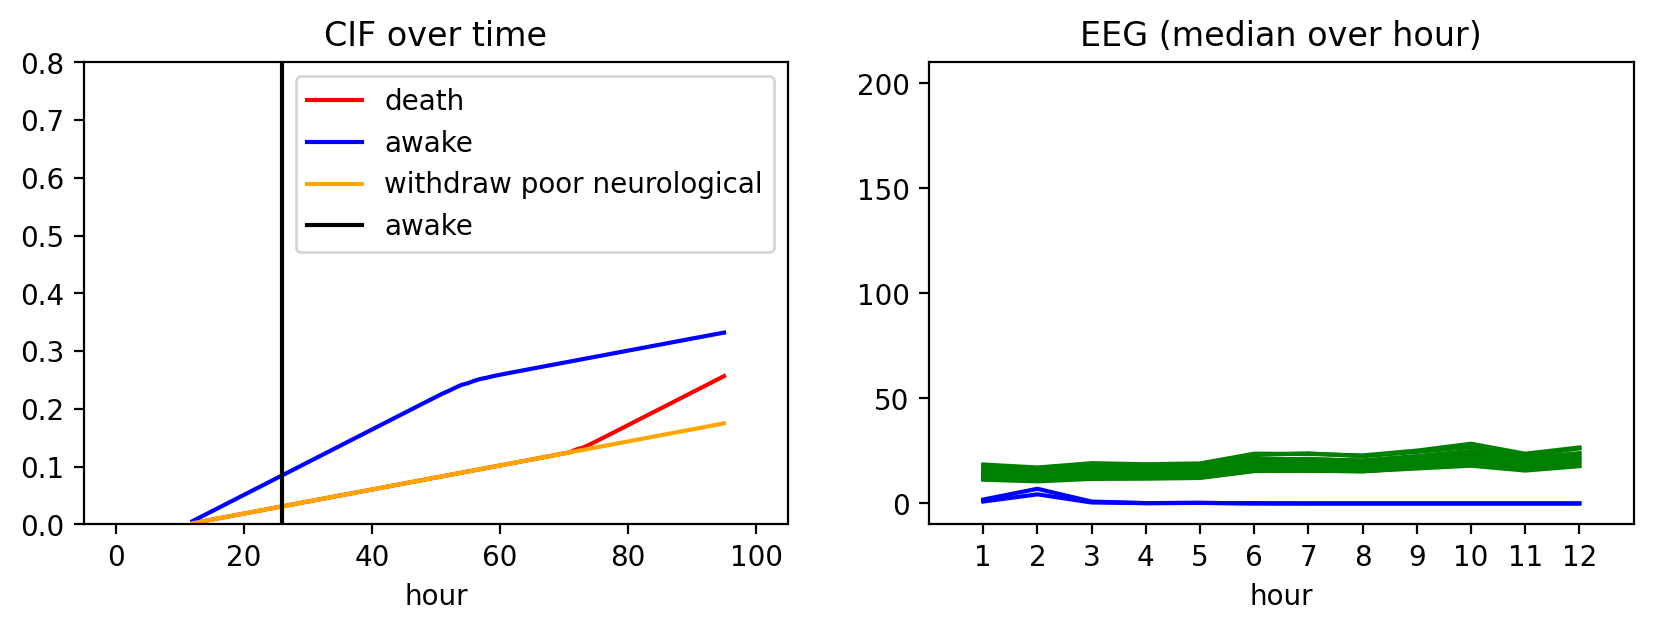

patient 23 time: 107.0 label: 3.0 withdraw poor neurological


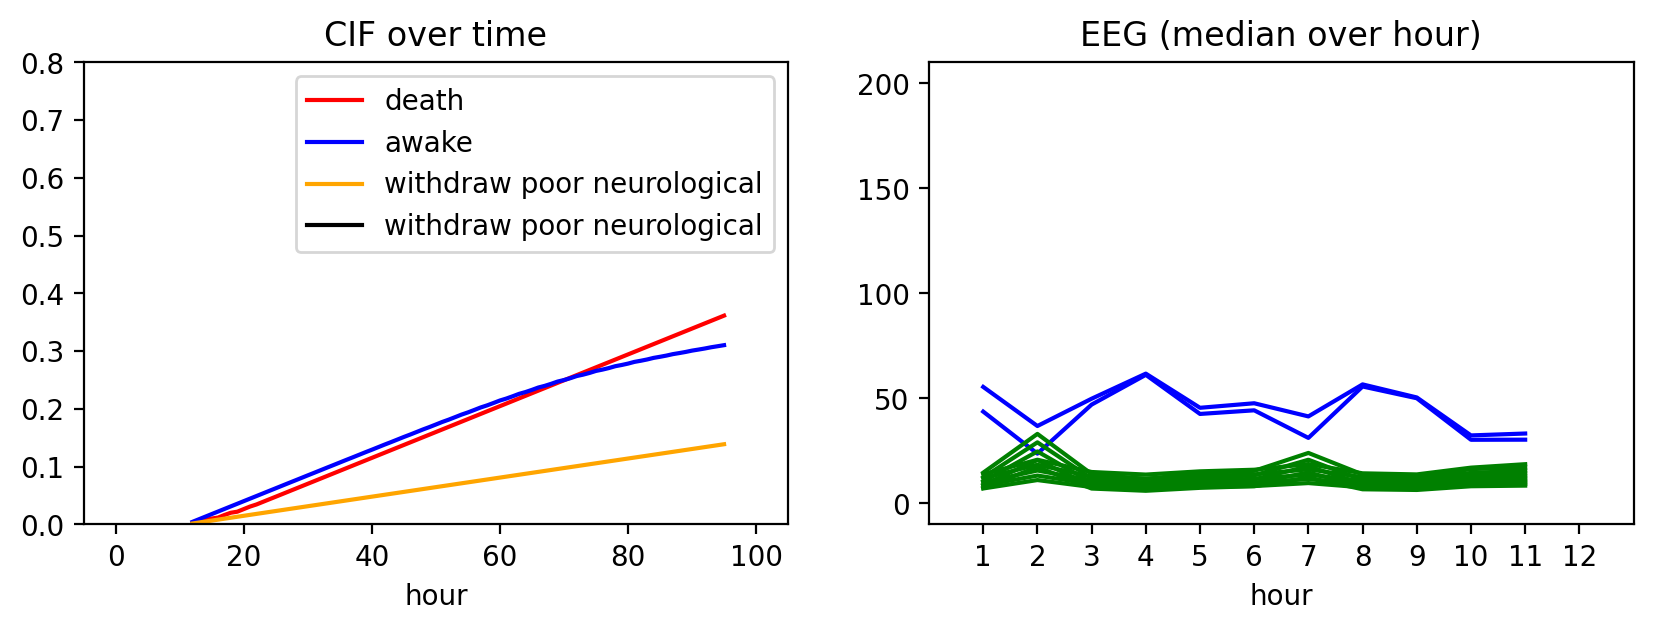

patient 24 time: 64.0 label: 3.0 withdraw poor neurological


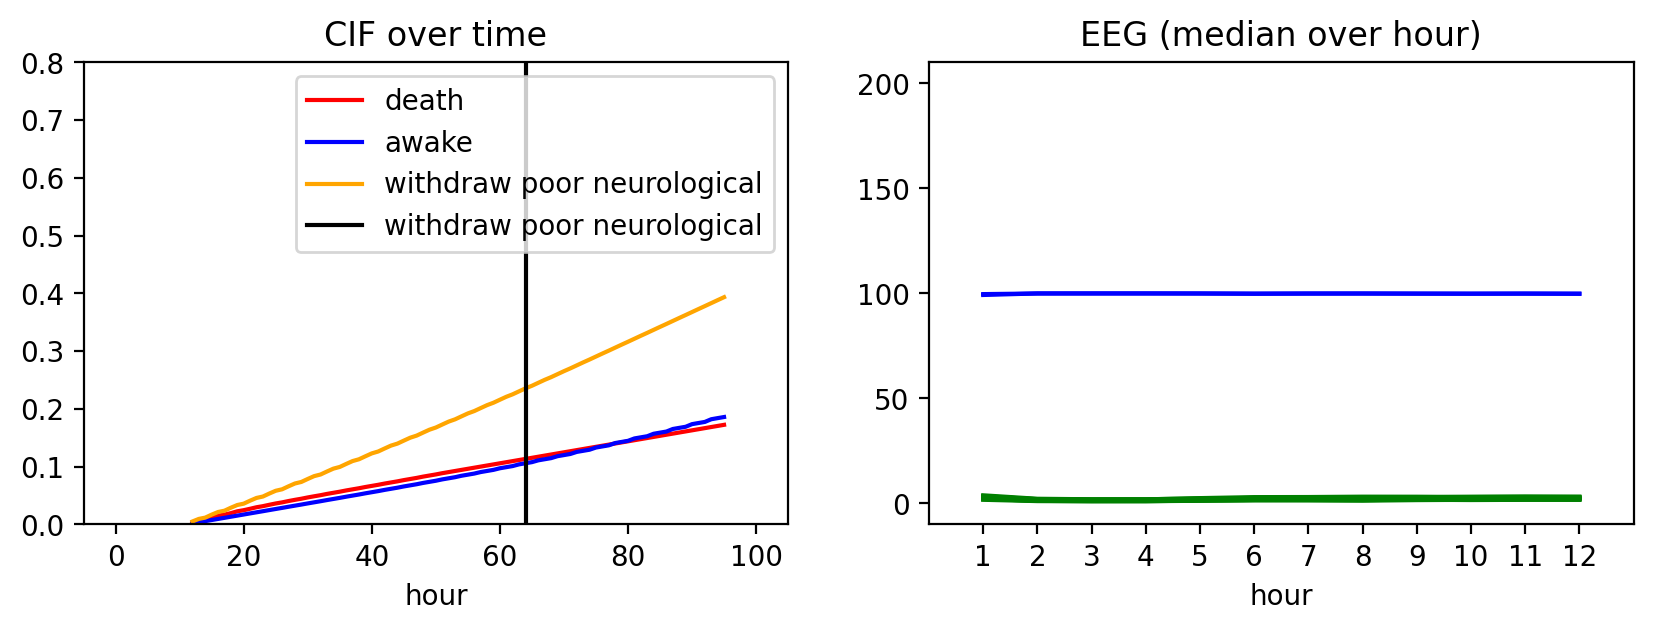

patient 25 time: 116.0 label: 3.0 withdraw poor neurological


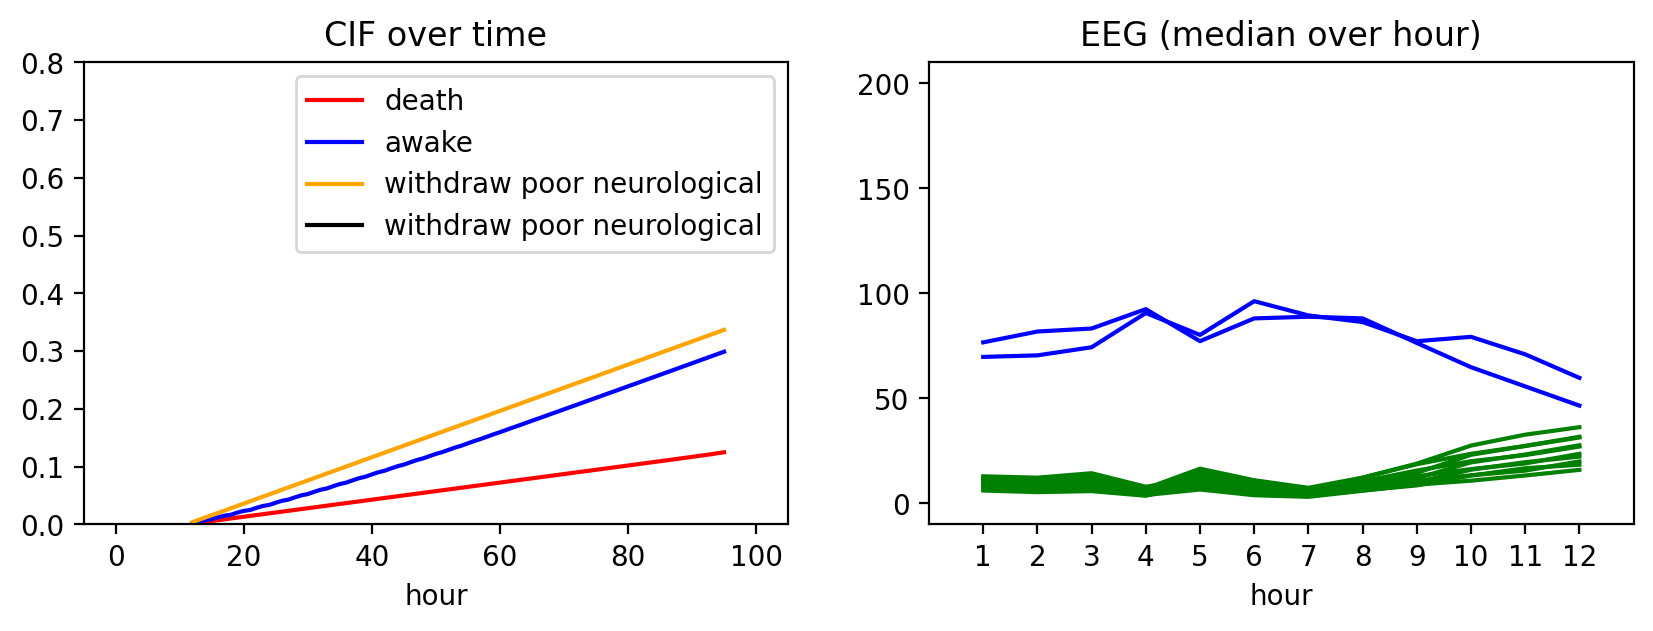

patient 26 time: 39.0 label: 2.0 awake


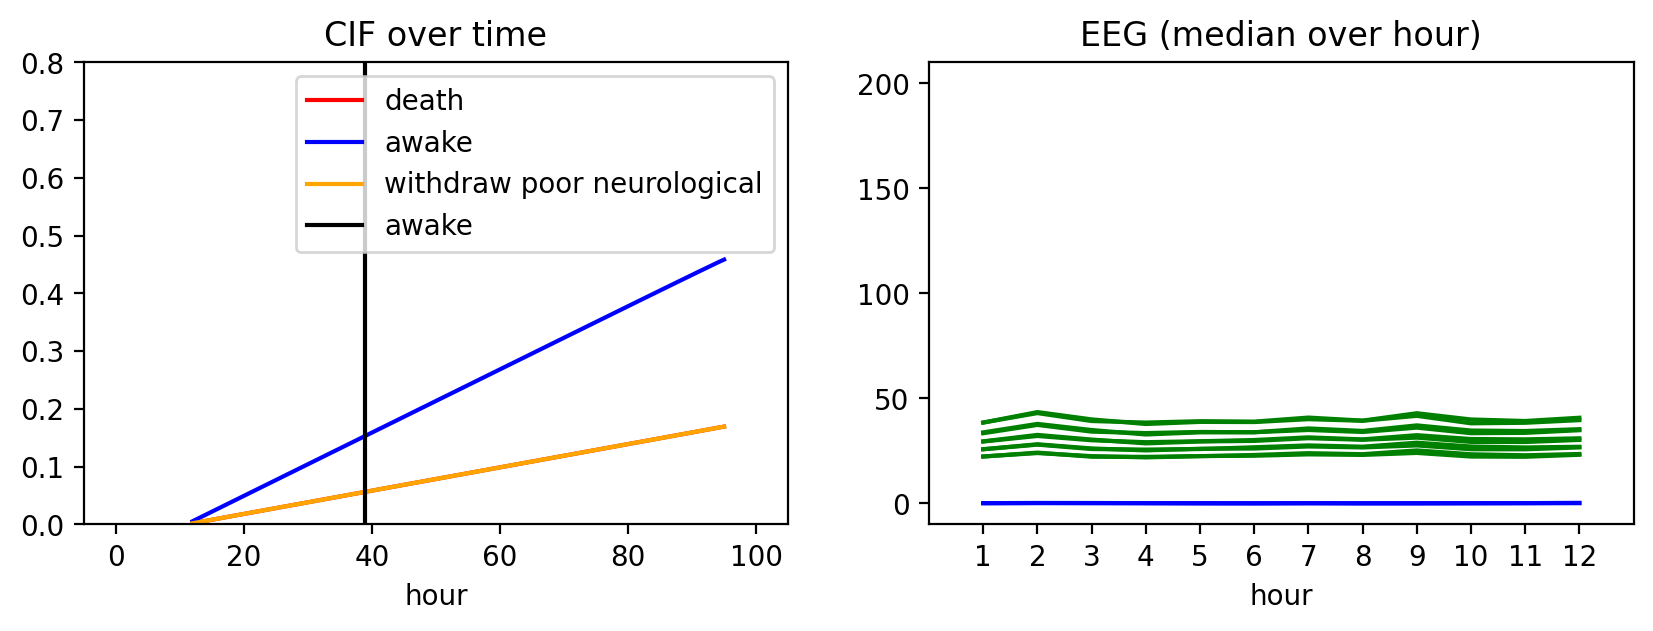

patient 27 time: 100.0 label: 1.0 death


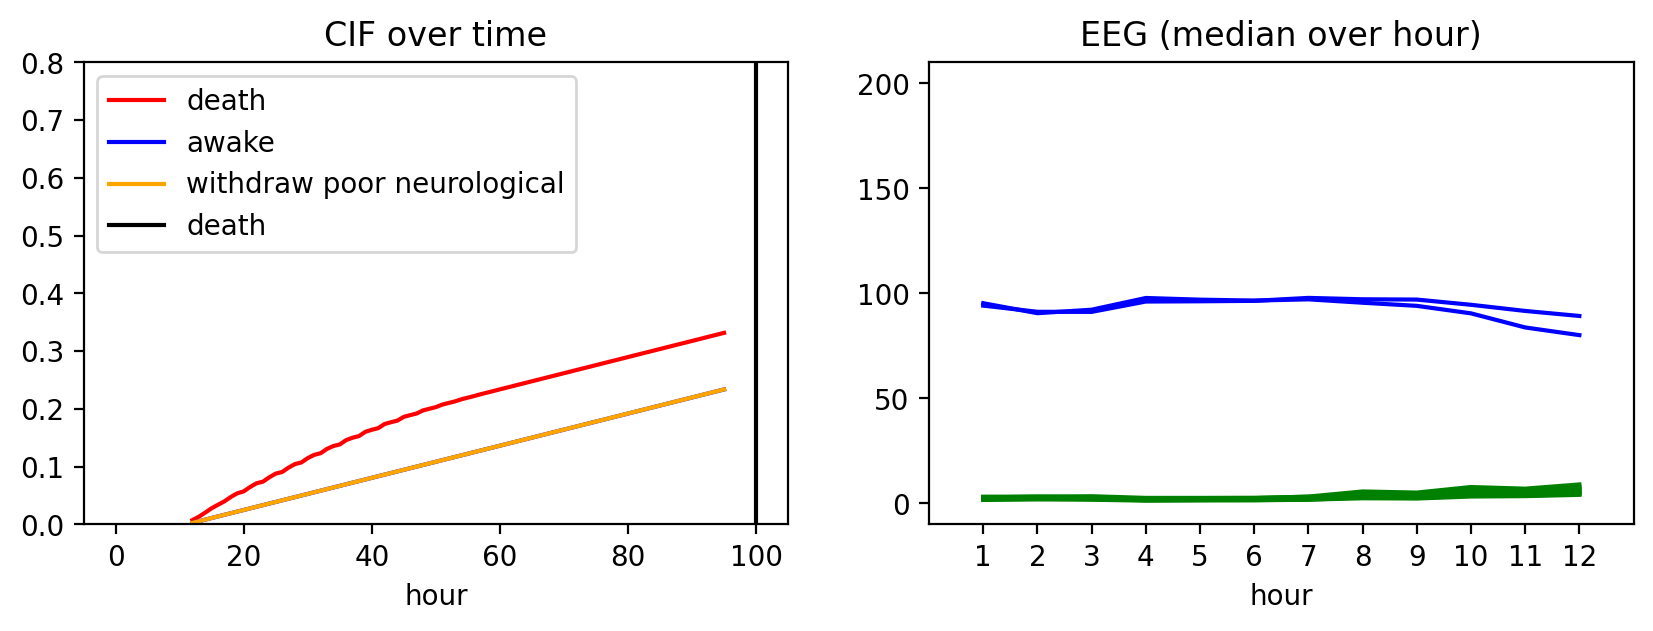

patient 28 time: 72.0 label: 3.0 withdraw poor neurological


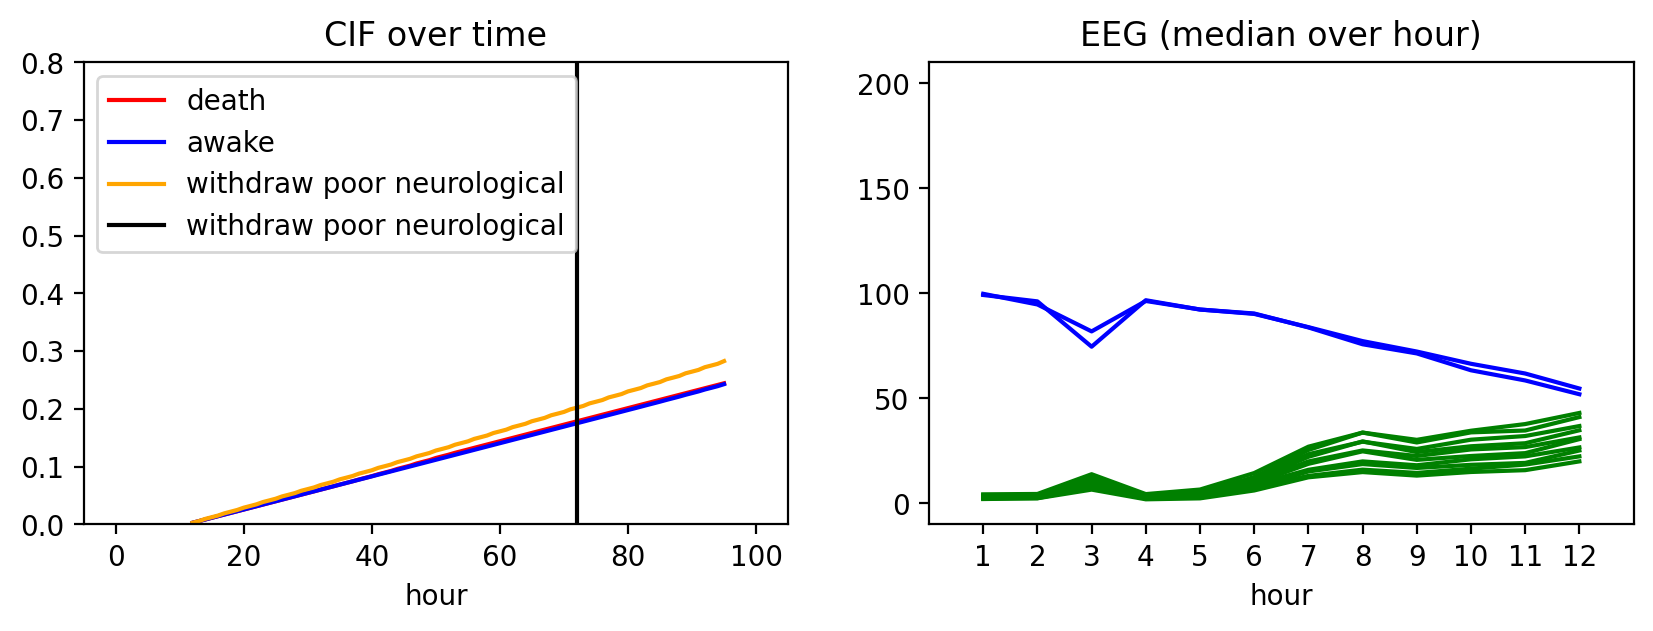

patient 29 time: 62.0 label: 1.0 death


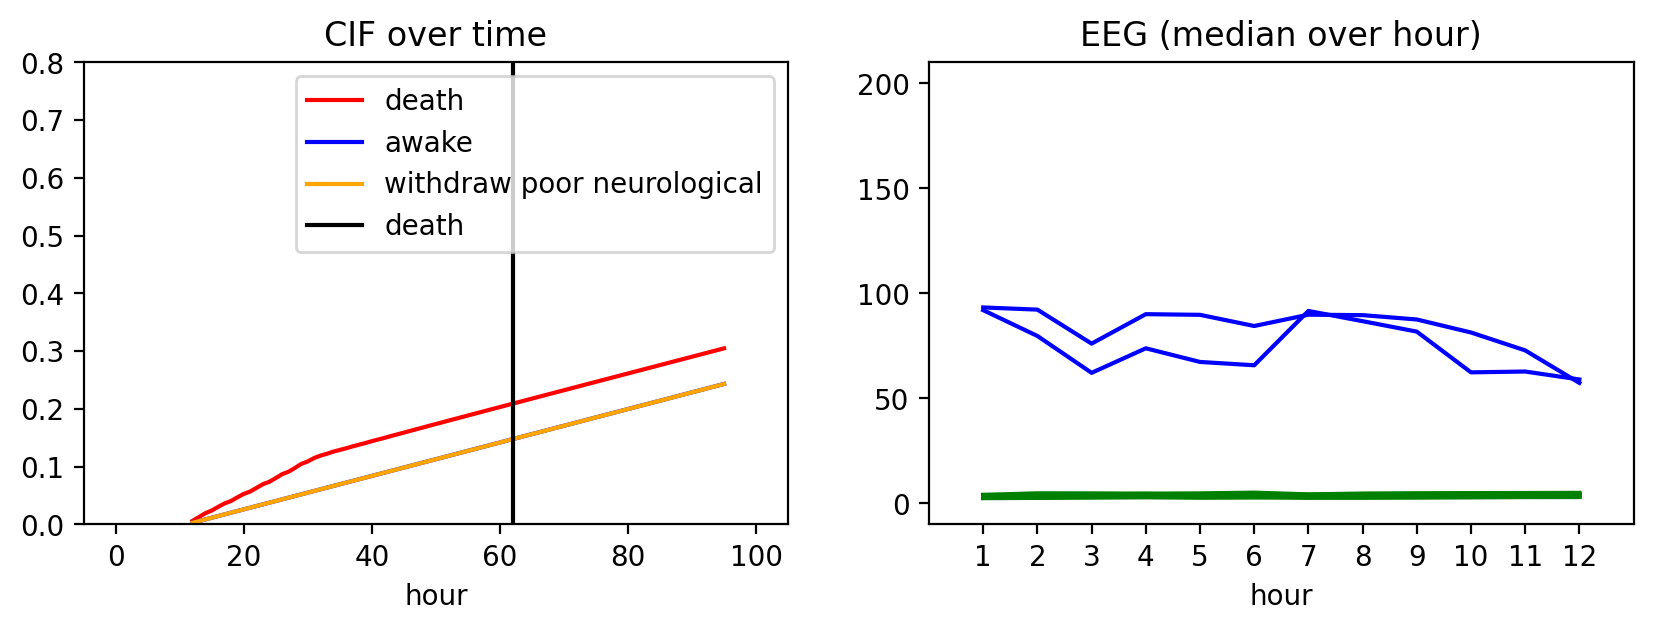

patient 30 time: 21.0 label: 2.0 awake


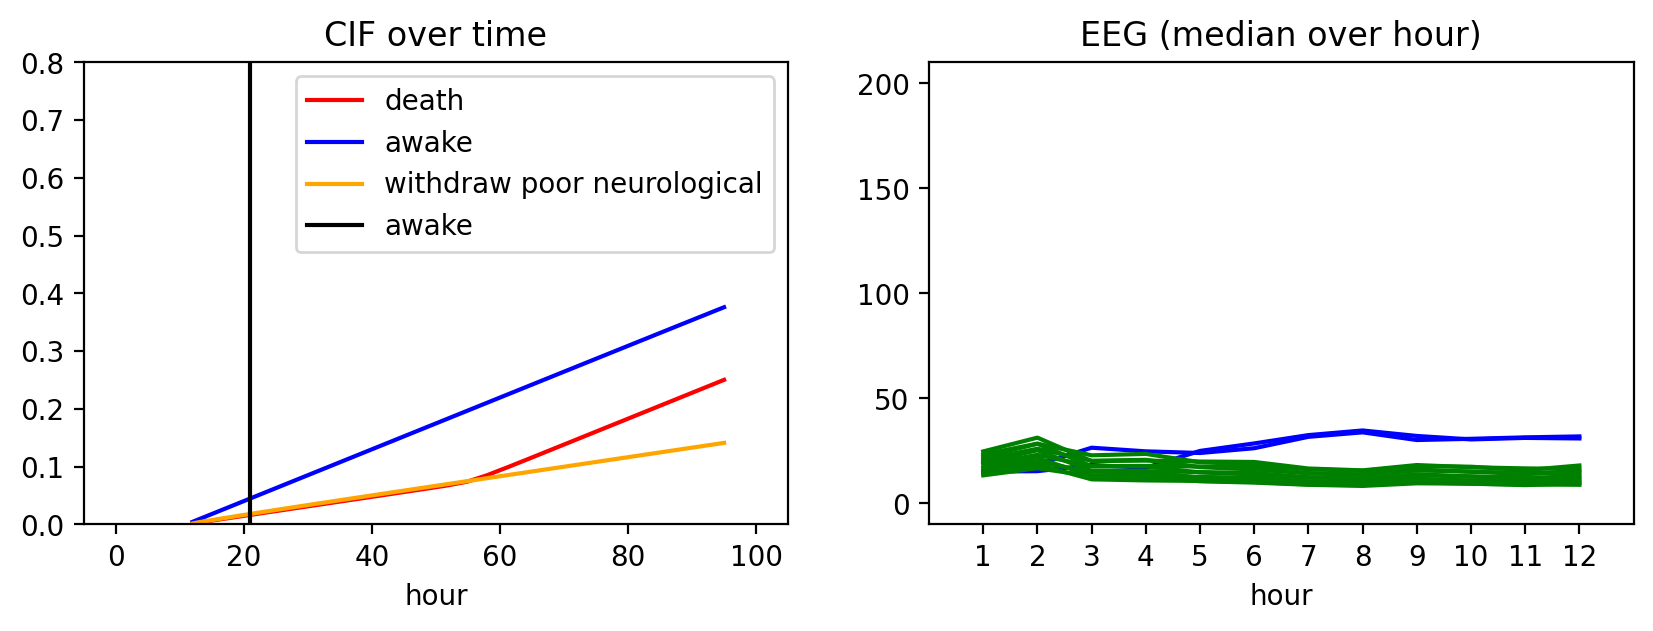

patient 31 time: 101.0 label: 3.0 withdraw poor neurological


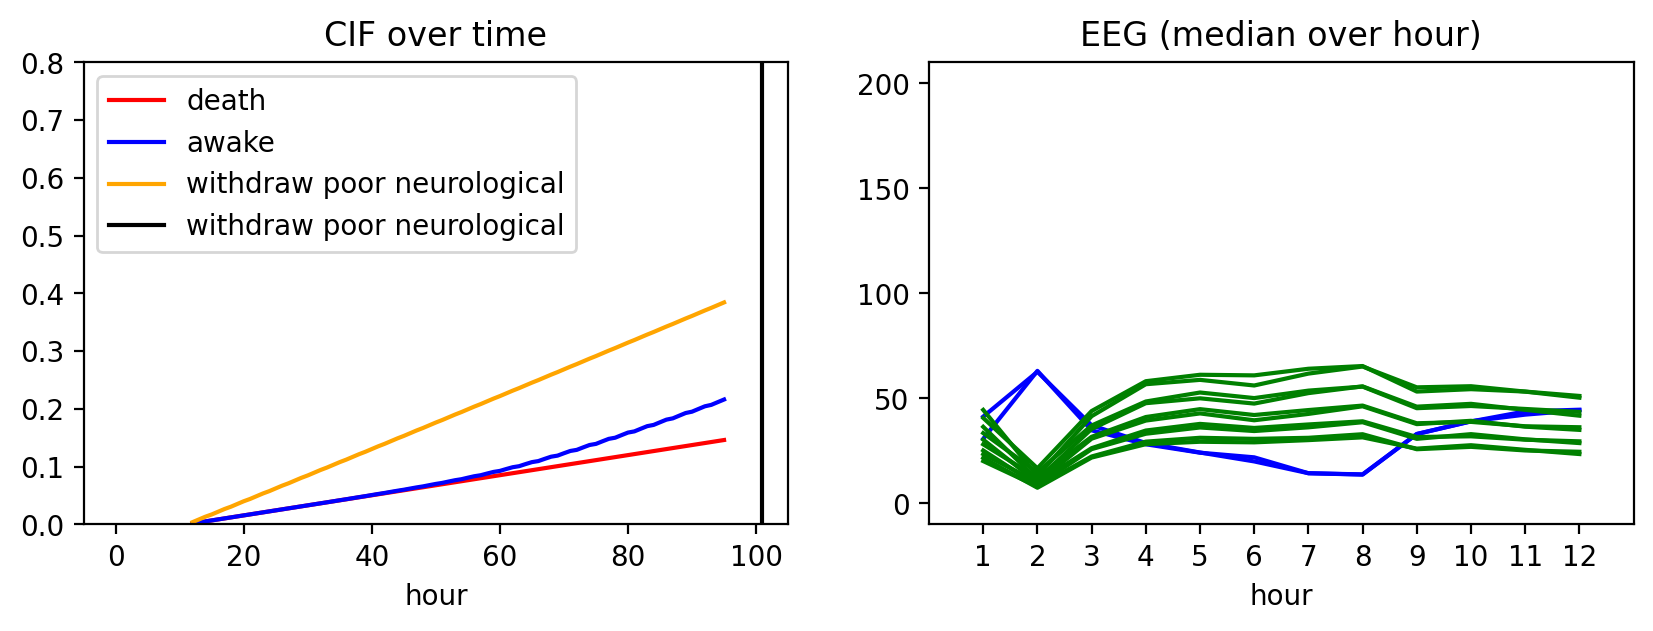

patient 32 time: 119.0 label: 3.0 withdraw poor neurological


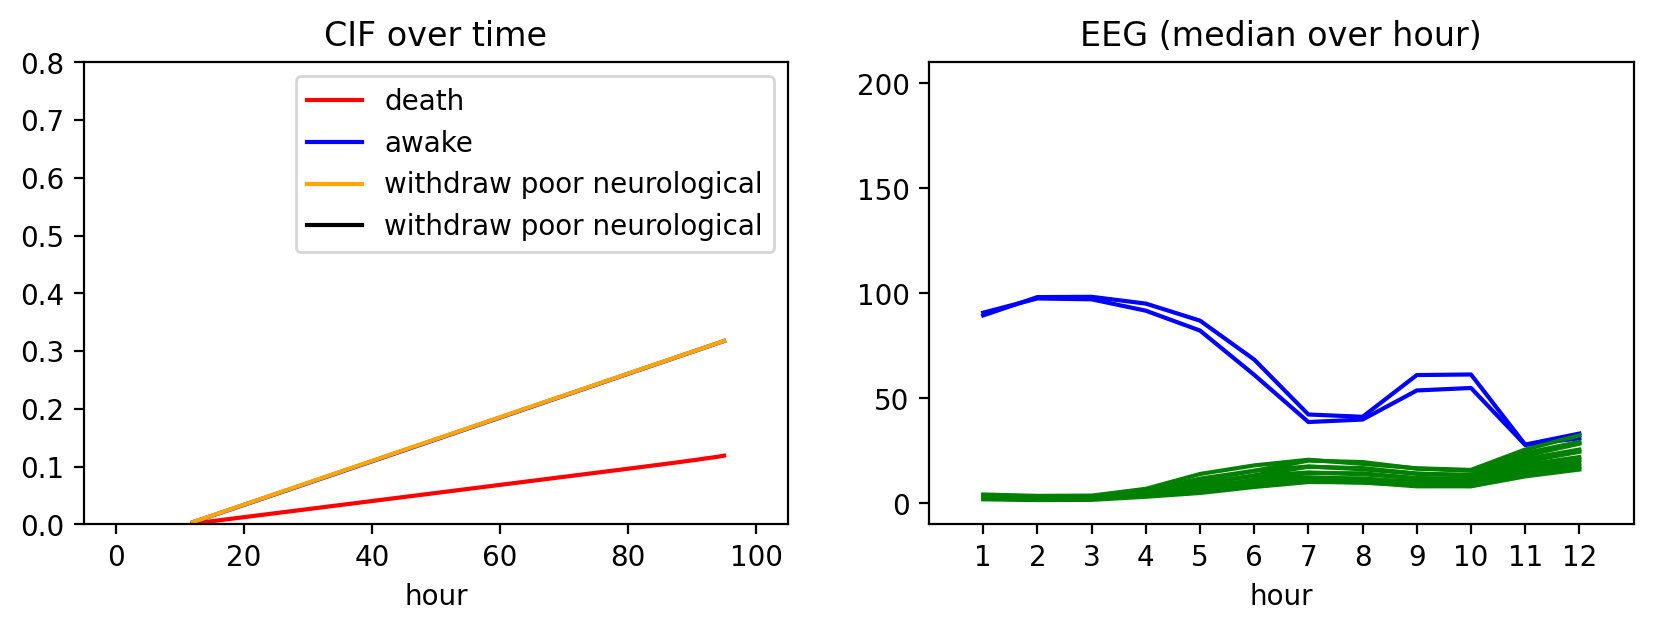

patient 33 time: 65.0 label: 2.0 awake


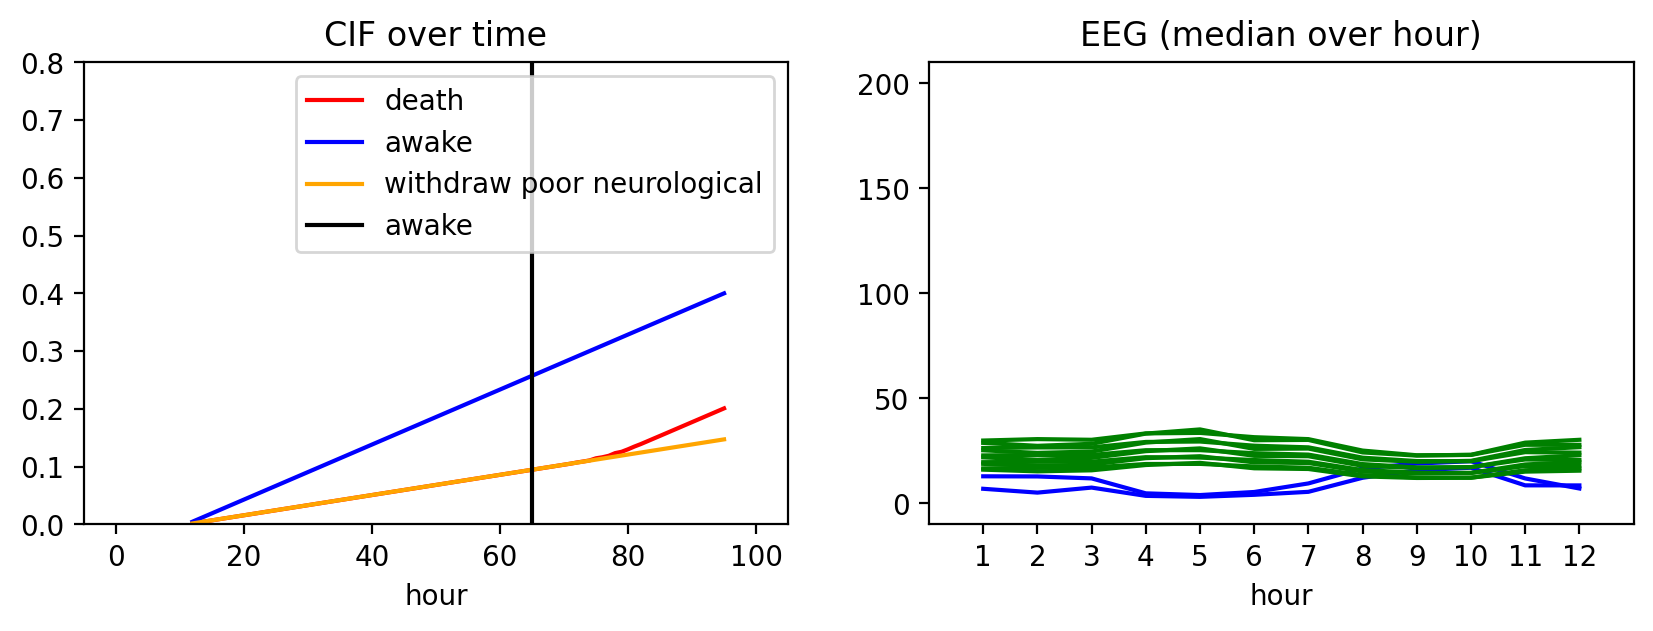

patient 34 time: 105.0 label: 3.0 withdraw poor neurological


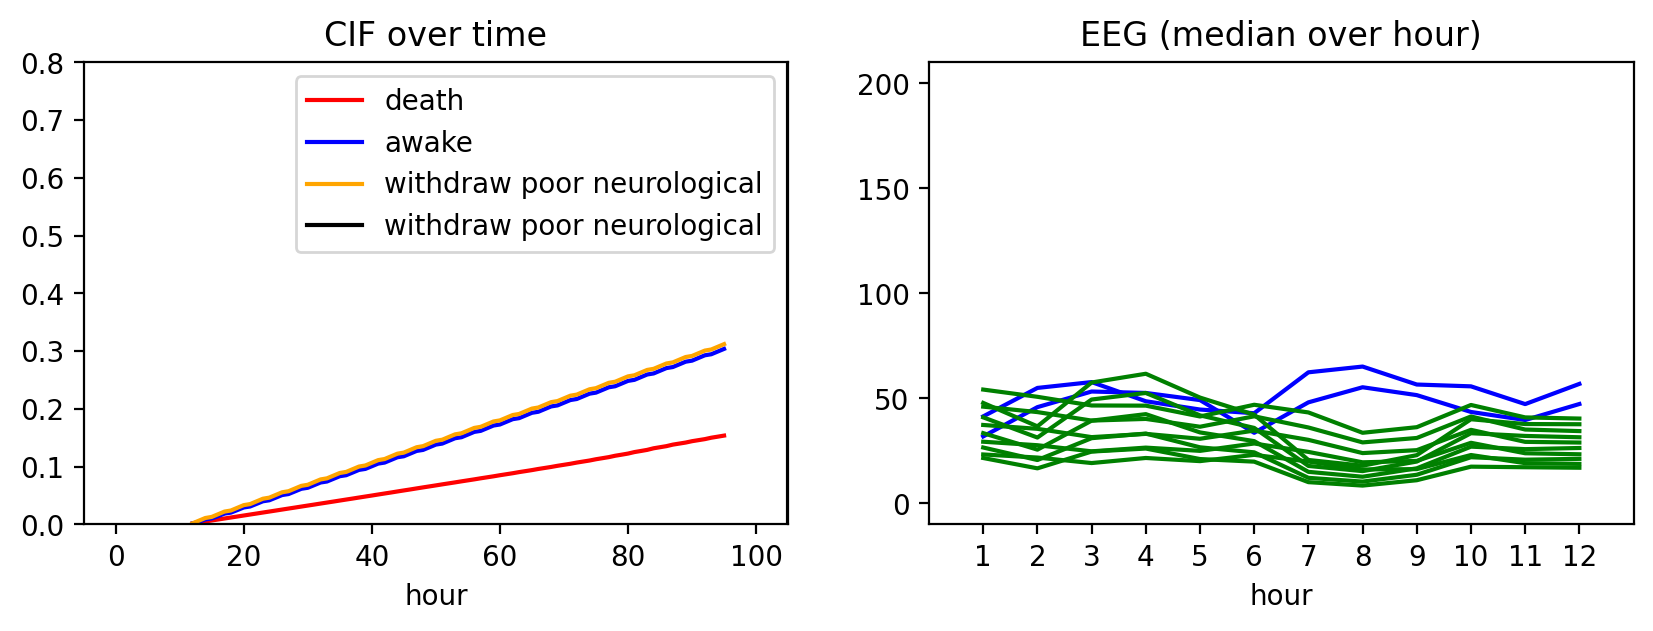

patient 35 time: 14.0 label: 1.0 death


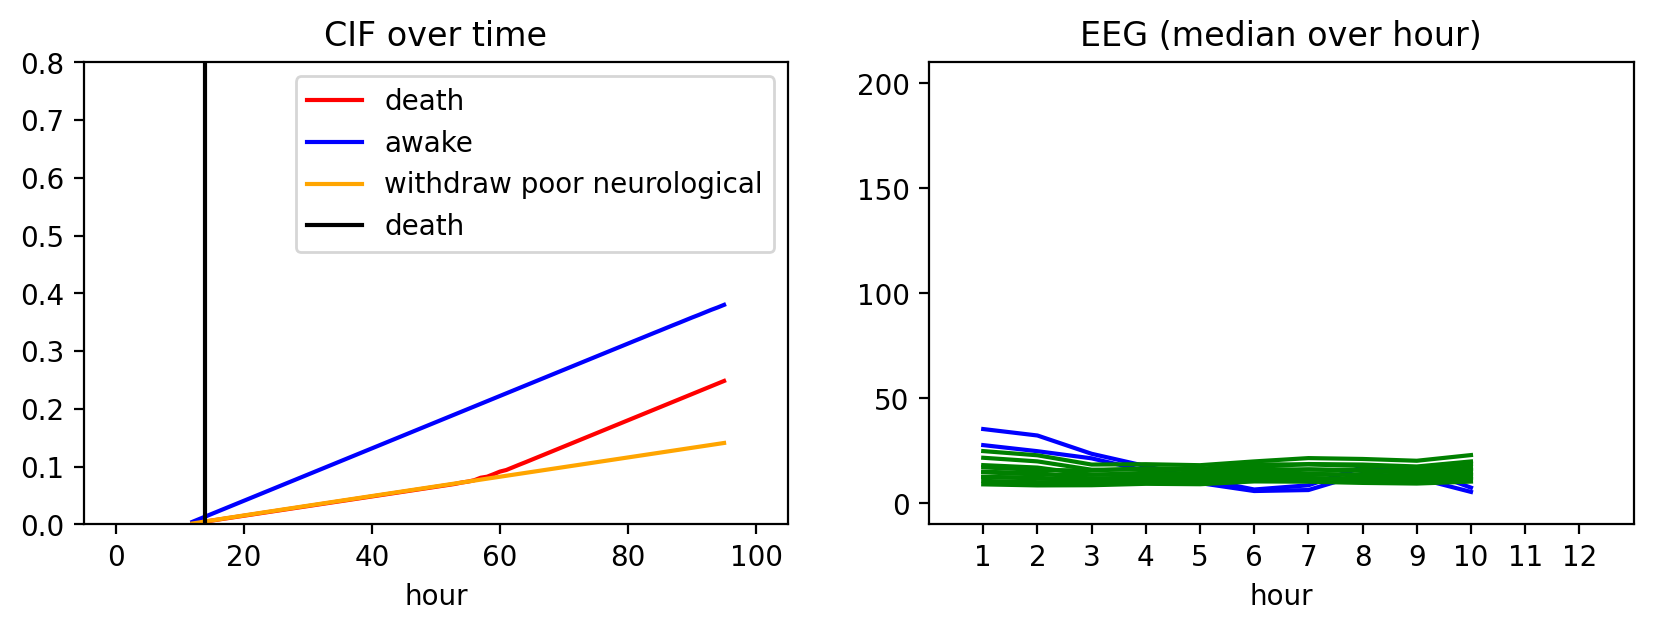

patient 36 time: 32.0 label: 2.0 awake


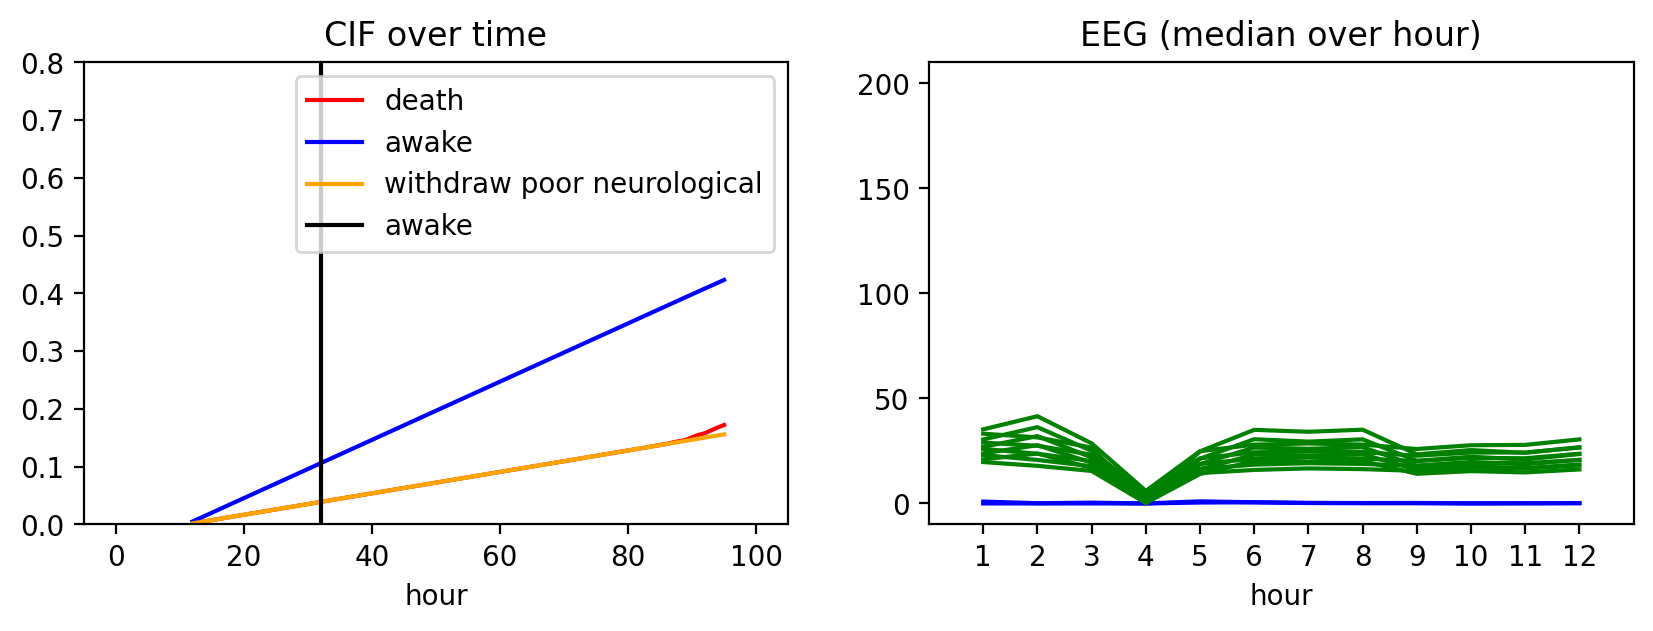

patient 37 time: 25.0 label: 2.0 awake


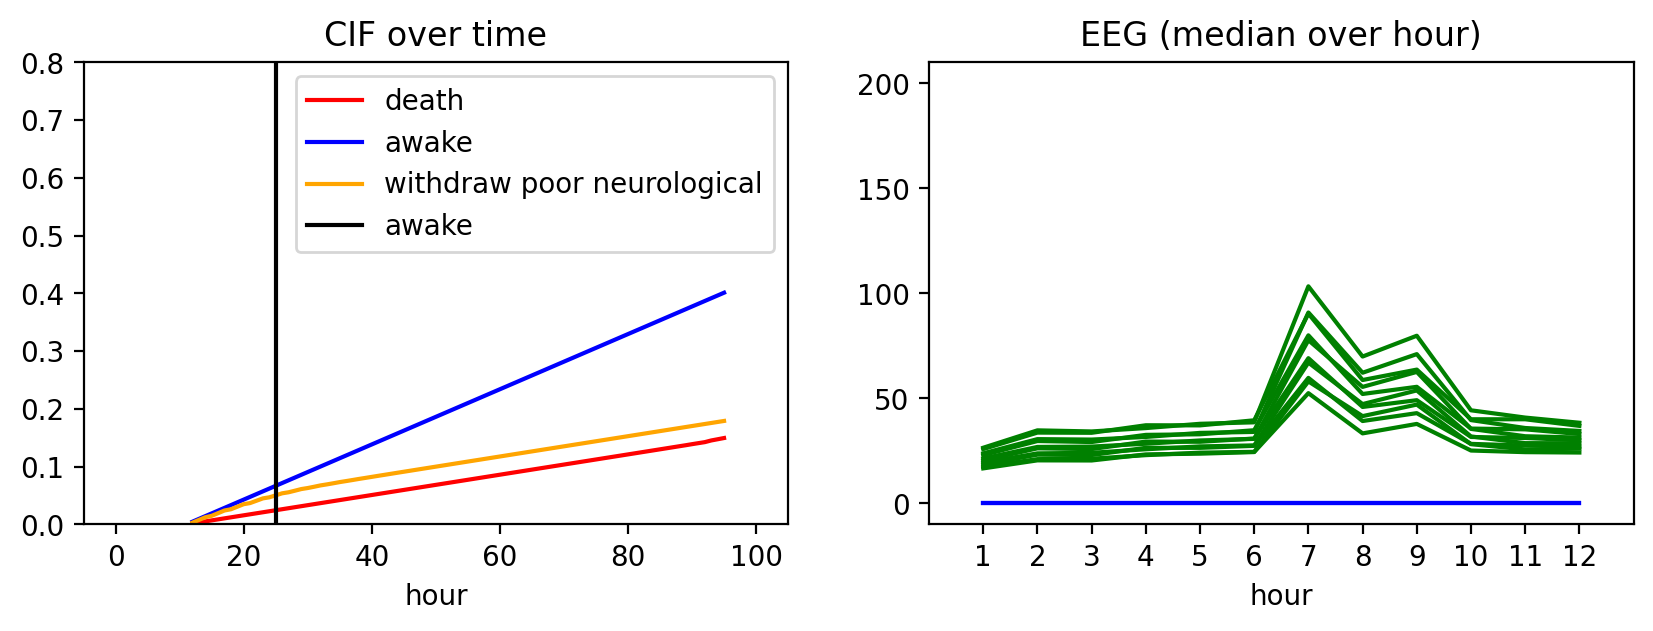

patient 38 time: 110.0 label: 3.0 withdraw poor neurological


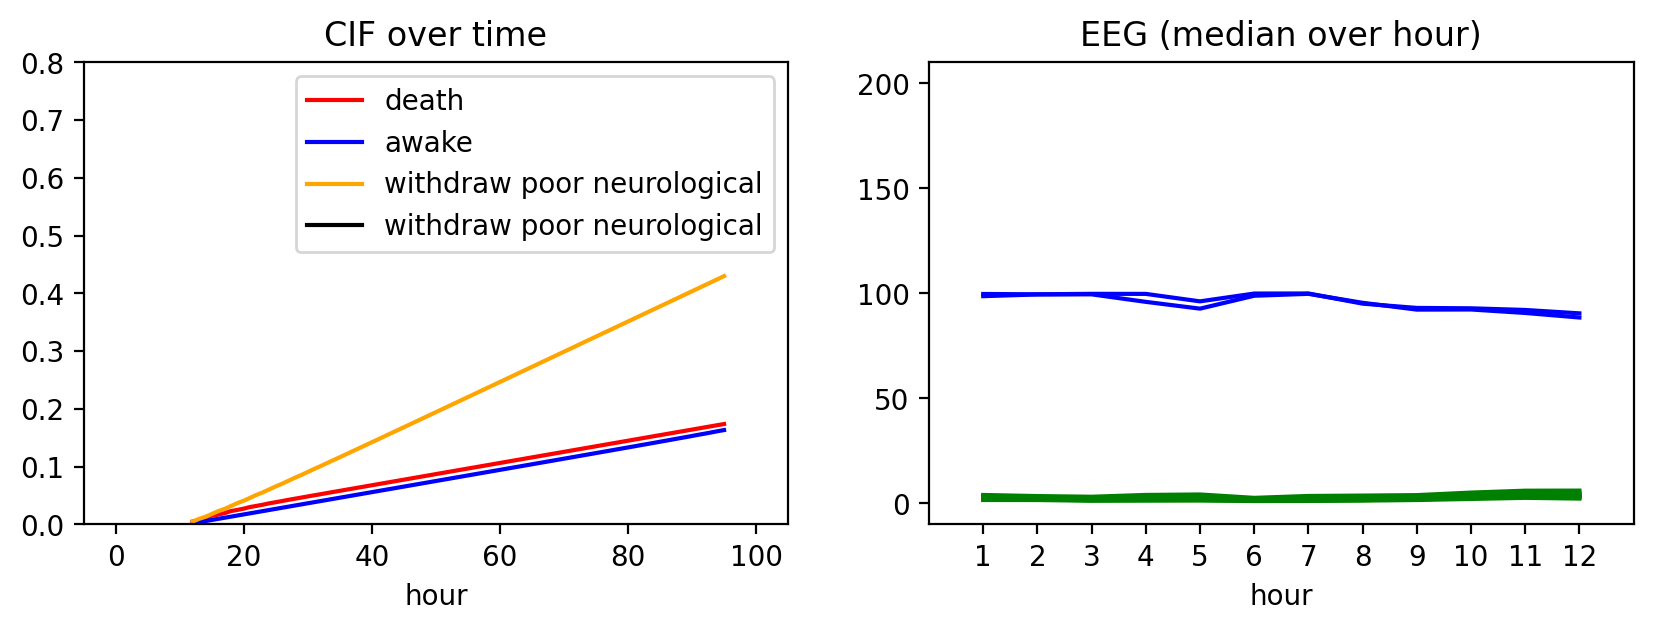

patient 39 time: 17.0 label: 1.0 death


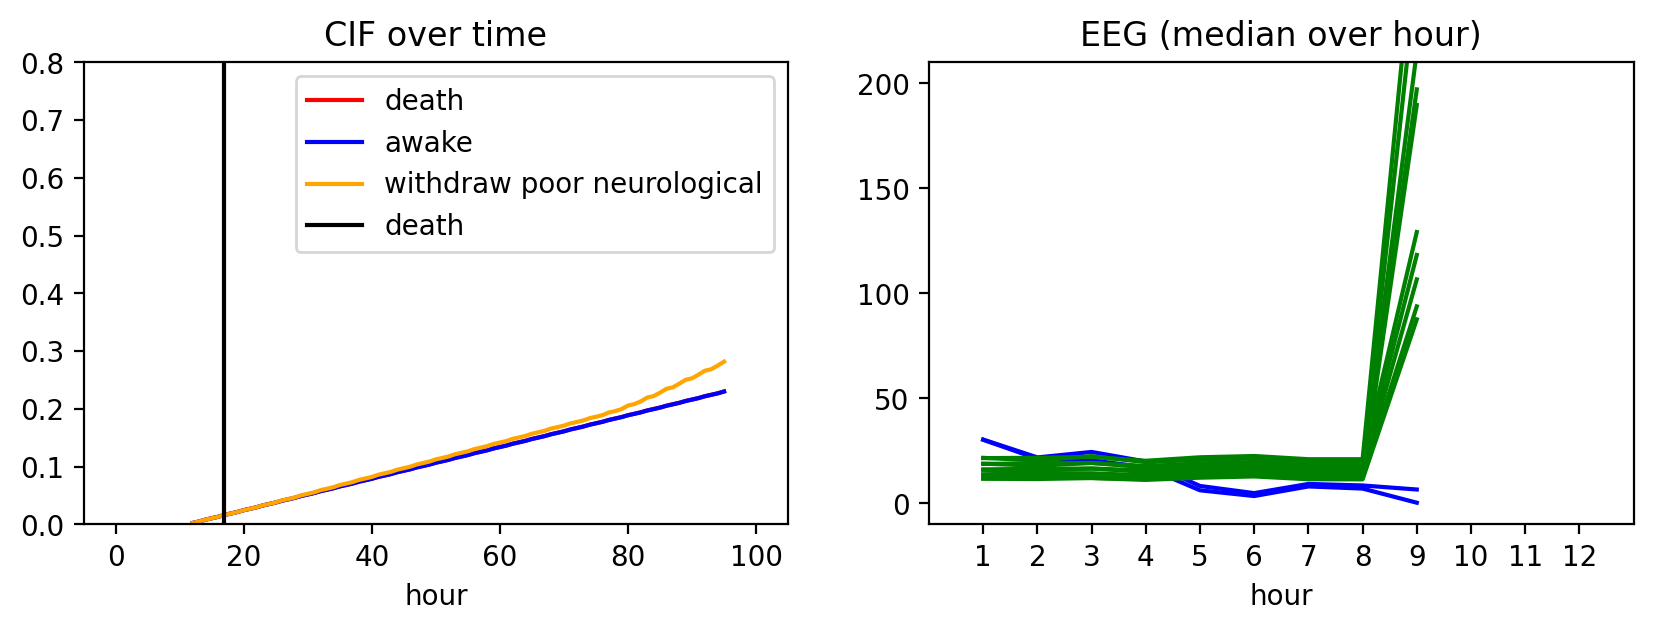

In [21]:
import matplotlib.pyplot as plt
plt.style.use('default')
%config InlineBackend.figure_format = 'retina'

pred_time = list(range(1,13))
eval_time = list(range(0,84))
risk_all = f_get_risk_predictions(model, te_data, pred_time, eval_time, device)
d = {0: 'censor', 1: 'death', 2: 'awake', 3: 'withdraw poor neurological'}


for i in [46, 11, 50, 20, 60, 80] + list(range(21,40)):
    print('patient', i, 'time:', te_time[i][0], 'label:', te_label[i][0], d[te_label[i][0]])
    fig = plt.figure(figsize=(10,3))
    
    ax = fig.add_subplot(121)
    # plt.figure(figsize=(4,2))
    event = 1
    plt.plot(list(range(12, 96)), risk_all[event-1][i][-1], c='red', label=d[event])
    event = 2
    plt.plot(list(range(12, 96)), risk_all[event-1][i][-1], c='blue', label=d[event])
    event = 3
    plt.plot(list(range(12, 96)), risk_all[event-1][i][-1], c='orange', label=d[event])
    plt.axvline(x = te_time[i][0], color = 'black', label = d[te_label[i][0]])
    plt.legend()
    plt.ylim(0,0.8)
    plt.xlim(-5, 105)
    plt.xlabel('hour')
    plt.title('CIF over time')
    #plt.show()
    
    ax = fig.add_subplot(122)
    # plt.figure(figsize=(4,2))
    te_data[i, :, 1]
    # m: 0-mean, 1-max, 2-min, 3-25quantile, 4-median, 5-75quantile
    m = 4
    X = te_data[i]; t_mask = ~(np.abs(X).sum(1) == 0)
    X = X[t_mask]
    x = X[:, m*12+1:m*12+13] # mean or max or min or ... of 12 features
    plt.ylim(-10,210)
    plt.xlim(-1, 12)
    dim = np.arange(1,13,1)
    plt.xticks(np.arange(len(dim)), np.arange(1,len(dim)+1))
    plt.plot(x[:, :2], c='blue') ## Suppression Ratio
    plt.plot(x[:, 2:], c='green') ## aEEG
    plt.xlabel('hour')
    plt.title('EEG (median over hour)')
    plt.show()

In [25]:
colors = ['red', 'blue', 'orange']

patient 0 time: 47.0 label: 2.0 awake


ValueError: x and y must have same first dimension, but have shapes (84,) and (4,)

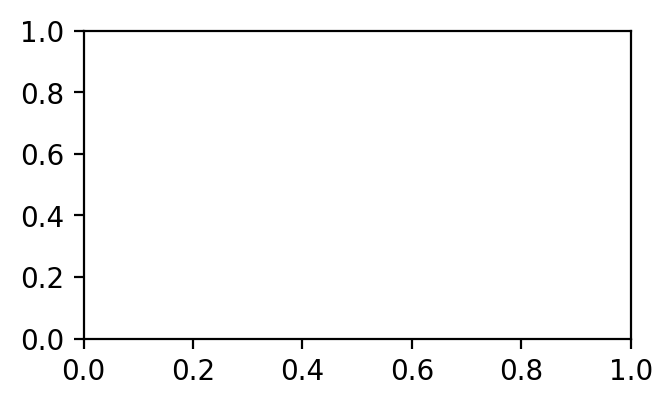

In [55]:
# at first 6 hour 
for i in range(185):
    print('patient', i, 'time:', te_time[i][0], 'label:', te_label[i][0], d[te_label[i][0]])
    fig = plt.figure(figsize=(12,2))
    
    ax = fig.add_subplot(131)
    # plt.figure(figsize=(4,2))
    event = 1
    plt.plot(list(range(6, 6+84)), risk_all[event-1][i][-1], c='red')#, label=d[event])
    event = 2
    plt.plot(list(range(6, 6+84)), risk_all[event-1][i][-1], c='blue')#, label=d[event])
    event = 3
    plt.plot(list(range(6, 6+84)), risk_all[event-1][i][-1], c='orange')#, label=d[event])
    plt.axvline(x = te_time[i][0], color = 'black', label = d[te_label[i][0]])
    plt.axvline(x = median_time[i], color = 'grey', label = 'pred '+d[pred_k[i]+1])
    plt.legend()
    plt.ylim(0,1)
    plt.xlim(-5, 105)
    plt.xlabel('hour')
    plt.title('CIF over time')
    #plt.show()
    
    ax = fig.add_subplot(132)
    # plt.figure(figsize=(4,2))
    te_data[i, :, 1]
    # m: 0-mean, 1-max, 2-min, 3-25quantile, 4-median, 5-75quantile
    m = 4
    X = te_data[i]; t_mask = ~(np.abs(X).sum(1) == 0)
    X = X[t_mask]
    x = X[:, m*12+1:m*12+13] # mean or max or min or ... of 12 features
    plt.ylim(-10,210)
    plt.xlim(-1, 12)
    dim = np.arange(1,13,1)
    plt.xticks(np.arange(len(dim)), np.arange(1,len(dim)+1))
    plt.plot(x[:, :2], c='blue', label='Suppression Ratio') ## Suppression Ratio
    plt.plot(x[:, 2:], c='green', label='aEEG') ## aEEG
    # plt.legend()
    plt.xlabel('hour')
    plt.title('EEG (median over hour)')
    
    ax = fig.add_subplot(133)
    event = 1
    plt.plot(prob_not_happen[i, event-1], c='red')
    event = 2
    plt.plot(prob_not_happen[i, event-1], c='blue')
    event = 3
    plt.plot(prob_not_happen[i, event-1], c='orange')
    plt.axvline(x = median_time[i], color = colors[pred_k[i]], label = 'pred '+d[pred_k[i]+1])
    plt.ylim(0,1)
    
    plt.show()

In [58]:
risk_all[0].shape

(185, 2, 4)

In [56]:
model

DDRSA(
  (embedding): LSTM(116, 64, num_layers=2, bias=False, batch_first=True)
  (longitudinal): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=64, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=116, bias=True)
  )
  (attention): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=180, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=64, bias=True)
    (6): ReLU()
    (7): Linear(in_features=64, out_features=1, bias=True)
  )
  (attention_soft): Softmax(dim=1)
  (cause_specific_rnn): ModuleList(
    (0): LSTMCell(180, 180, bias=False)
    (1): LSTMCell(180, 180, bias=False)
    (2): LSTMCell(180, 180, bias=False)
  )
  (cause_specific): ModuleList(
    (0): Sequential(
      (0): Dropout(p=0.2, in

In [27]:
from scipy.stats import pearsonr
def cal_pearsonr(a,b):
    return pearsonr(a, b)[0]

death_mask = te_label.flatten() == 1
awake_mask = te_label.flatten() == 2
withdrawl_mask = te_label.flatten() == 3
non_censor_mask = (te_label.flatten() != 0)

print(cal_pearsonr(median_time[non_censor_mask], te_time.flatten()[non_censor_mask]))
print(cal_pearsonr(median_time[awake_mask], te_time.flatten()[awake_mask]))
print(cal_pearsonr(median_time[death_mask], te_time.flatten()[death_mask]))
print(cal_pearsonr(median_time[withdrawl_mask], te_time.flatten()[withdrawl_mask]))

0.1613058826777804
0.17093818024379784
0.1413297004942176
0.12719105537108955


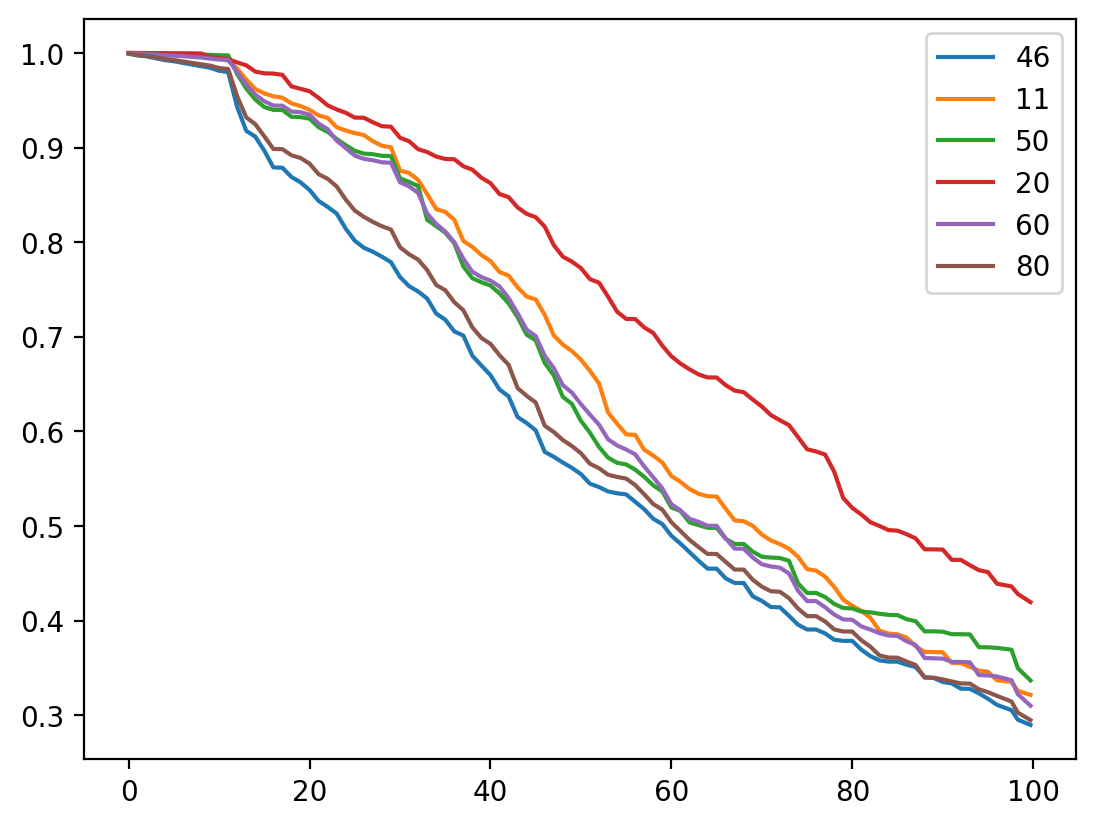

In [130]:
for i in [46, 11, 50, 20, 60, 80]:
    plt.plot(intp_index[:-20], intp_surv[i][:-20], label=i)
    # plt.xscale('log')

# plt.xticks(intp_index)

# intp_surv, intp_index = interpolate_surv_fn(pred_surv, trans_discrete_time, sub=10)
# plt.plot(intp_index, intp_surv[i], label='intp')

# intp_surv, intp_index = interpolate_surv_fn(pred_surv, trans_discrete_time, sub=50)
# plt.plot(intp_index, intp_surv[i], label='intp')

plt.legend()

In [73]:
intp_index[:5], intp_index[-5:], 

(array([0. , 0.1, 0.2, 0.3, 0.4]),
 array([1394.4, 1585.8, 1777.2, 1968.6, 2160. ]))

In [72]:
intp_index.shape

(1191,)

In [74]:
intp_surv[i].shape

(1191,)